In [145]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)


2.12.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hsibitenda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hsibitenda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [146]:
# from google.colab import drive
# drive.mount('/content/drive')
import torch

print(torch.cuda.is_available())

if torch.cuda.is_available():
    print("Cuda is Availabe")
else:
    print("Cuda Can't be found")

True
Cuda is Availabe


In [147]:
#new_df=pd.read_csv('C:/Users/Administrator/OneDrive/Documents/africa/data/socialcons_all_new.csv')
new_df = pd.read_csv('/home/hsibitenda/scratch/harriet/socialcons_clean2_rebel5_new.csv')
# new_df=pd.read_csv('D:/senego/dataafrica/analysis/socialcons_all_new.csv')
# new_df=pd.read_csv("C:/Users/Administrator/Downloads/bert.csv")

In [148]:
new_df.shape

(66862, 20)

In [149]:
# !pip install accelerate -U

df=new_df.copy()
df=df.astype(str)

In [150]:
df.shape

(66862, 20)

In [151]:
df.rename(columns={'llama2_labelone10':'cluster','llama2_labelone': 'topic','Predicted_Categories3':'theme','llama3_sentiment':'sentiment', 'Entity_Categories2':'category' },inplace=True)
df.columns

Index(['Unnamed: 0', 'sourcetype', 'Views', 'Date', 'textid', 'alltext',
       'topic', 'cleaned_theme', 'cluster', 'theme', 'sentiment', 'Text_lemma',
       'Entities', 'Relations', 'Entity_Categories', 'Head', 'Relation_Type',
       'Tail', 'Spans', 'category'],
      dtype='object')

In [152]:
#df.groupby(['Top_n_words'])['Text_lemma'].count()
d=df['topic'].value_counts()
d.head(20)

topic
visa application process in australia for african nationals                                                                                          27000
nan                                                                                                                                                   4399
science exam questions and reactions                                                                                                                  2512
overcoming anxiety disorder                                                                                                                           1320
hacking for business                                                                                                                                   894
entrepreneurial innovation challenge                                                                                                                   665
"spiritual infertility consultation"                            

In [153]:
df = df[df['topic'].isin([
    'science exam questions and reactions',
    'hacking for business',
    'entrepreneurial innovation challenge',
    'spiritual infertility consultation',
    'youth unemployment and poverty in south africa',
    'trademarks',
    'corruption and governance in developing countries',
    'water & environmental challenge: innovating for climate resilience',
    'ghanaian election news',
    'cricket match fails on tiktok',
    'streamed parliament reaction in february'
])][['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]
df.shape

(6137, 9)

In [154]:
df2=df.head(3)
df2.columns

Index(['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations',
       'category', 'Views'],
      dtype='object')

In [155]:
df2.head()

topic        Date       theme  \
95   science exam questions and reactions  2022-08-24  employment   
96   science exam questions and reactions  2022-08-24  employment   
203                  hacking for business         nan      others   

                                                  Head  \
95   abbreviation em th class abbreviation paper pa...   
96                                       abbreviations   
203  access finance smes seye olurotomi ugwumba center   

                                                  Tail sentiment  \
95   abbreviation em th class abbreviation paper pa...   neutral   
96                                        abbreviation   neutral   
203                                      great nigeria   neutral   

                                             Relations  \
95   [{'head': 'abbreviation em th class abbreviati...   
96   [{'head': 'abbreviation em th class abbreviati...   
203  [{'head': 'access finance smes seye olurotomi ...   

                           category Views  
95                               []    55  
96                               []    55  
203  ['locations', 'organisations']   253

In [156]:
import pandas as pd

# Define the possible themes
themes = ['poverty', 'hunger', 'health', 'employment', 'education', 'security', 'others']

# Function to expand the dataframe based on multilabels by duplicating rows
# Function to expand the dataframe based on multilabels by duplicating rows
def expand_multilabel(df, column):
    # Split the multilabel column and create a new row for each label
    df_expanded = df.copy()
    df_expanded[column] = df_expanded[column].str.split('|')  # Split the multilabel column
    df_expanded = df_expanded.explode(column)  # Duplicate rows for each label
    return df_expanded

# Apply the function to expand the Predicted_Categories3 column
df_expanded = expand_multilabel(df, 'theme')

# Display the expanded dataframe
print(df_expanded)

                                      topic                       Date  \
95     science exam questions and reactions                 2022-08-24   
96     science exam questions and reactions                 2022-08-24   
203                    hacking for business                        nan   
204                    hacking for business                        nan   
205                    hacking for business                        nan   
...                                     ...                        ...   
66786                            trademarks  2019-08-09 09:21:04+00:00   
66787                            trademarks  2019-08-09 09:21:04+00:00   
66809  science exam questions and reactions                 2021-08-24   
66810  science exam questions and reactions                 2021-08-24   
66811  science exam questions and reactions                 2021-08-24   

            theme                                               Head  \
95     employment  abbreviation em th c

In [157]:
df_expanded.shape

(8812, 9)

In [158]:
# # pip install folium

df_education = df_expanded[df_expanded['theme'] == 'education']
df_poverty = df_expanded[df_expanded['theme'] == 'poverty']
df_health = df_expanded[df_expanded['theme'] == 'health']
df_employment = df_expanded[df_expanded['theme'] == 'employment']
df_security = df_expanded[df_expanded['theme'] == 'security']
df_hunger = df_expanded[df_expanded['theme'] == 'hunger']
print(df_education.shape)


(1035, 9)


In [159]:
df_expanded['category']

95                                   []
96                                   []
203      ['locations', 'organisations']
204      ['locations', 'organisations']
205                   ['organisations']
                      ...              
66786                                []
66787                     ['locations']
66809                       ['persons']
66810                       ['persons']
66811                       ['persons']
Name: category, Length: 8812, dtype: object

In [160]:
# Filter rows where 'people' is in the list within the 'category' column
df_people = df_expanded[df_expanded['category'].apply(lambda x: 'persons' in x)]
df_org = df_expanded[df_expanded['category'].apply(lambda x: 'organisations' in x)]
df_country = df_expanded[df_expanded['category'].apply(lambda x: 'locations' in x)]


# Check the shape of the resulting dataframe
df_people.shape


(1265, 9)

In [161]:
df_org.shape

(865, 9)

In [162]:
df_country.shape

(732, 9)

In [163]:
# df=df_org.head(1000)
df.columns

Index(['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations',
       'category', 'Views'],
      dtype='object')

In [164]:
df2

topic        Date       theme  \
95   science exam questions and reactions  2022-08-24  employment   
96   science exam questions and reactions  2022-08-24  employment   
203                  hacking for business         nan      others   

                                                  Head  \
95   abbreviation em th class abbreviation paper pa...   
96                                       abbreviations   
203  access finance smes seye olurotomi ugwumba center   

                                                  Tail sentiment  \
95   abbreviation em th class abbreviation paper pa...   neutral   
96                                        abbreviation   neutral   
203                                      great nigeria   neutral   

                                             Relations  \
95   [{'head': 'abbreviation em th class abbreviati...   
96   [{'head': 'abbreviation em th class abbreviati...   
203  [{'head': 'access finance smes seye olurotomi ...   

                           category Views  
95                               []    55  
96                               []    55  
203  ['locations', 'organisations']   253

## Community Detection

In [165]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd  # Assuming you're using pandas

# # Load your dataset into a DataFrame named 'df2' from the uploaded file
# # Assuming df2 is already created and available
# df_subset = df2[['Head', 'Tail', 'Relation_Type', 'theme', 'sentiment', 'category', 'topic']]

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges to the graph
# for _, row in df_subset.iterrows():
#     head = row['Head']
#     tail = row['Tail']
#     relation_type = row['Relation_Type']
#     theme = row['theme']
#     sentiment = row['sentiment']
#     category = row['category']
#     topic = row['topic']
    
#     # Add nodes for Head and Tail
#     G.add_node(head, type='Entity', label='Head')
#     G.add_node(tail, type='Entity', label='Tail')
    
#     # Add edge between Head and Tail with Relation_Type as edge label
#     G.add_edge(head, tail, type=relation_type)
    
#     # Add other attributes and edges related to the entities (except cluster)
#     G.add_node(theme, type='Theme')
#     G.add_node(sentiment, type='Sentiment')
#     G.add_node(category, type='Category')
#     G.add_node(topic, type='Topic')

#     # Add edges from Head and Tail to other attributes
#     G.add_edge(head, sentiment, type='Sentiment')
#     G.add_edge(head, theme, type='Theme')
#     G.add_edge(head, category, type='Category')
#     G.add_edge(head, topic, type='Topic')

#     G.add_edge(tail, sentiment, type='Sentiment')
#     G.add_edge(tail, theme, type='Theme')
#     G.add_edge(tail, category, type='Category')
#     G.add_edge(tail, topic, type='Topic')

# # Adjust the layout for better node spacing
# pos = nx.spring_layout(G, k=2.0)  # Increase k to spread out the nodes

# # Get edge labels (including relation types between head and tail)
# edge_labels = nx.get_edge_attributes(G, 'type')

# # Get node degrees for node size
# node_weights = {node: weight for node, weight in nx.degree(G)}

# # Draw the graph with nodes and edges
# nx.draw(G, pos, with_labels=False, node_size=[v * 100 for v in node_weights.values()], node_color='skyblue', font_color='black' )

# # Label the nodes (Head, Tail, and others)
# for node, (x, y) in pos.items():
#     if node in df_subset['Head'].values:
#         plt.text(x, y + 0.05, f"{node} (Head)", fontsize=8, ha='center', va='center', fontweight='bold', color='blue')  # Mark Head
#     elif node in df_subset['Tail'].values:
#         plt.text(x, y + 0.05, f"{node} (Tail)", fontsize=8, ha='center', va='center', fontweight='bold', color='red')  # Mark Tail
#     else:
#         plt.text(x, y + 0.02, node, fontsize=9, ha='center', va='center')  # Other nodes

# # Draw edge labels (for Relation_Type, Sentiment, Theme, etc.)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Show the plot
# plt.show()


In [166]:
df.shape

(6137, 9)

Epoch 0, Loss: 1.4745720624923706
Epoch 10, Loss: 0.5093166828155518
Epoch 20, Loss: 0.16556985676288605
Epoch 30, Loss: 0.07131657004356384
Epoch 40, Loss: 0.04663329944014549
Epoch 50, Loss: 0.03851954638957977
Epoch 60, Loss: 0.03592472895979881
Epoch 70, Loss: 0.03432410582900047
Epoch 80, Loss: 0.03260759264230728
Epoch 90, Loss: 0.031213076785206795
Node embeddings:
tensor([[1.0298, 1.0421, 1.0275, 1.0386, 1.0238, 1.0327, 1.0337, 1.0409, 1.0430,
         1.0352, 1.0302, 1.0400, 1.0297, 1.0315, 1.0323, 1.0203],
        [1.0861, 1.0880, 1.0839, 1.0852, 1.0630, 1.0854, 1.0826, 1.0827, 1.0839,
         1.0846, 1.0859, 1.0867, 1.0811, 1.0844, 1.0831, 1.0631],
        [0.8614, 0.8675, 0.8634, 0.8663, 0.8775, 0.8645, 0.8727, 0.8676, 0.8702,
         0.8616, 0.8530, 0.8662, 0.8649, 0.8640, 0.8671, 0.8670],
        [0.7306, 0.7346, 0.7357, 0.7348, 0.7659, 0.7346, 0.7488, 0.7364, 0.7396,
         0.7287, 0.7162, 0.7336, 0.7377, 0.7346, 0.7398, 0.7498],
        [0.7306, 0.7346, 0.7357, 0.73

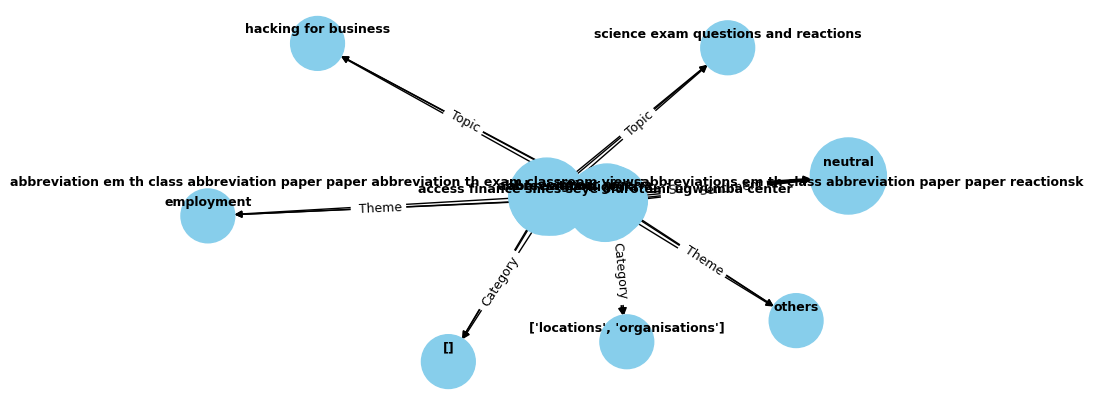

In [167]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns and remove 'cluster'
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])  # Assuming 'Relations' is a list of dictionaries
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'Date' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use node features if available, or create dummy features (e.g., all ones)
num_nodes = len(G.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature (dummy features)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Train the GCN model (example with random training for simplicity)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Now 'embeddings' contains the GNN embeddings for each node
# You can access the embedding of a specific node by index (e.g., embeddings[0] for the first node)
print("Node embeddings:")
print(embeddings)

# Visualize the graph based on embeddings
# Create a subgraph to visualize nodes with the highest degree (for simplicity)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]  # Top 20 nodes by degree
subgraph = G.subgraph([node[0] for node in top_nodes])

# Compute layout for plotting using NetworkX
pos = nx.spring_layout(subgraph)

# Get node sizes based on degree
node_sizes = [500 * G.degree[node] for node in subgraph.nodes()]

# Figure for visualization
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the graph
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color='skyblue', font_size=6, font_weight='bold', ax=ax)

# Add node labels, slightly adjusting positions to prevent overlap
for node, (x, y) in pos.items():
    ax.text(x, y + 0.05, s=node, fontsize=9, fontweight='bold', horizontalalignment='center')

# Draw edge labels for relations
edge_labels = nx.get_edge_attributes(subgraph, 'type')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=9)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()

# Save the entire graph with density to a GEXF file (for use in Gephi)
nx.write_gexf(G, 'graph_with_gnn_embeddings.gexf')


Epoch 0, Loss: 1.138227105140686
Epoch 10, Loss: 0.755251944065094
Epoch 20, Loss: 0.5229005813598633
Epoch 30, Loss: 0.3792162537574768
Epoch 40, Loss: 0.27922800183296204
Epoch 50, Loss: 0.21497879922389984
Epoch 60, Loss: 0.16785746812820435
Epoch 70, Loss: 0.13113974034786224
Epoch 80, Loss: 0.10175926238298416
Epoch 90, Loss: 0.07814814150333405
Node embeddings:
tensor([[0.8014, 0.8107, 0.8004,  ..., 0.8217, 0.8037, 0.7988],
        [0.8535, 0.8632, 0.8563,  ..., 0.8741, 0.8510, 0.8548],
        [0.7785, 0.7875, 0.7757,  ..., 0.7986, 0.7827, 0.7741],
        ...,
        [0.7785, 0.7875, 0.7757,  ..., 0.7986, 0.7827, 0.7741],
        [0.8014, 0.8107, 0.8004,  ..., 0.8217, 0.8037, 0.7988],
        [0.7785, 0.7875, 0.7757,  ..., 0.7986, 0.7827, 0.7741]])


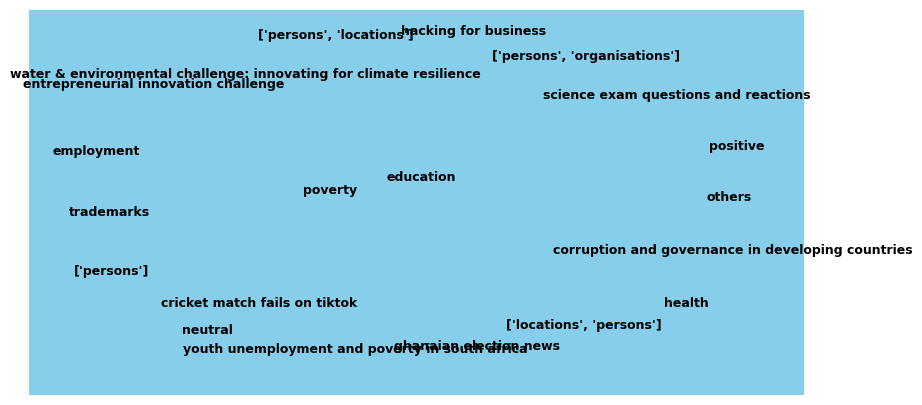

In [169]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns, removing 'cluster'
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])  # Assuming this is a list of relations
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']  # Assuming there is a 'Date' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    # Add nodes for Head and Tail
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use node features if available, or create dummy features (e.g., all ones)
num_nodes = len(G.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature (dummy features)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Train the GCN model (example with random training for simplicity)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Now 'embeddings' contains the GNN embeddings for each node
# You can access the embedding of a specific node by index (e.g., embeddings[0] for the first node)
print("Node embeddings:")
print(embeddings)

# Visualize the graph based on embeddings
# Create a subgraph to visualize nodes with the highest degree (for simplicity)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]  # Top 20 nodes by degree
subgraph = G.subgraph([node[0] for node in top_nodes])

# Compute layout for plotting using NetworkX
pos = nx.spring_layout(subgraph)

# Get node sizes based on degree
node_sizes = [500 * G.degree[node] for node in subgraph.nodes()]

# Figure for visualization
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the graph
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color='skyblue', font_size=6, font_weight='bold', ax=ax)

# Add node labels, slightly adjusting positions to prevent overlap
for node, (x, y) in pos.items():
    ax.text(x, y + 0.05, s=node, fontsize=9, fontweight='bold', horizontalalignment='center')

# Draw edge labels for relations
edge_labels = nx.get_edge_attributes(subgraph, 'type')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=9)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()

# Save the entire graph with density to a GEXF file (for use in Gephi)
nx.write_gexf(G, 'graph_with_gnn_embeddings21.gexf')


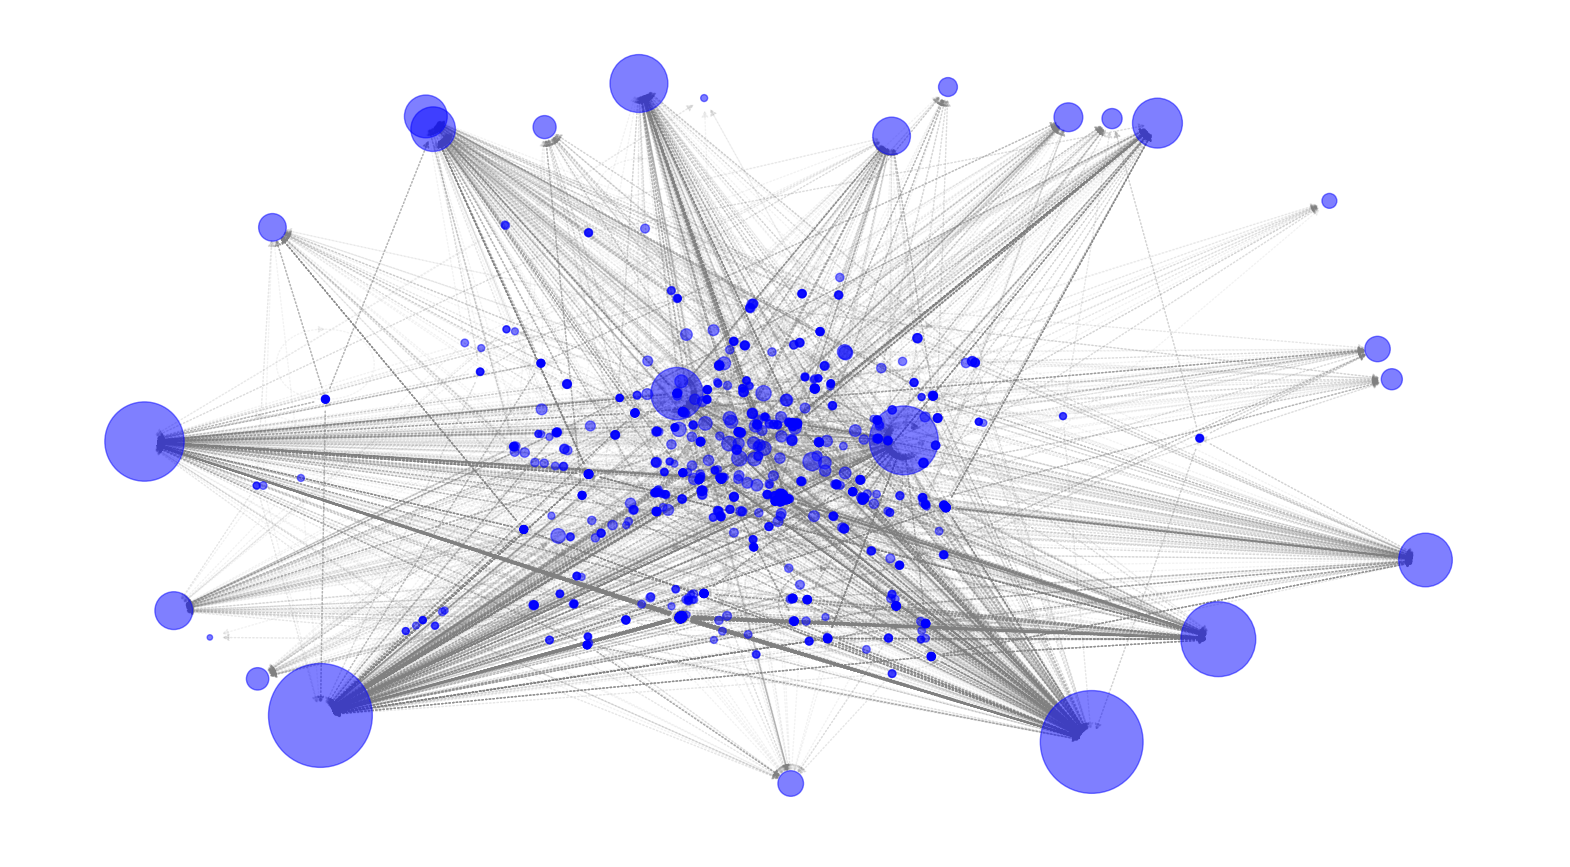

In [86]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns, removing 'cluster'
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])  # Assuming 'Relations' is a list of dictionaries
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'Date' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Compute node sizes based on degree
node_sizes = [5 * G.degree[node] for node in G.nodes()]

# Figure
fig, ax = plt.subplots(figsize=(20, 11))

# Map "pos" attribute to nodes from pos dict
for node, position in pos.items():
    G.nodes[node]['pos'] = position

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=nx.get_node_attributes(G, 'pos'), node_color='blue', alpha=0.5,
                       node_size=node_sizes)

# Draw edges
nx.draw_networkx_edges(G=G, pos=nx.get_node_attributes(G, 'pos'), edge_color='grey', style="dotted", alpha=0.1,
                       arrows=True)

# Hide axis
ax.axis('off')

# Watermark
ax.text(0.99, 0.01, ' ',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='grey',
        fontsize=15,
        alpha=0.9)

# Show the plot
plt.show()


In [87]:
import networkx as nx

# Assuming 'G' is your graph
top_nodes_by_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by degree:")
for node, degree in top_nodes_by_degree:
    print(f"Node: {node}, Degree: {degree}")


Top ten nodes by degree:
Node: neutral, Degree: 1118
Node: ['persons'], Degree: 1095
Node: others, Degree: 652
Node: science exam questions and reactions, Degree: 581
Node: poverty, Degree: 491
Node: health, Degree: 347
Node: employment, Degree: 298
Node: education, Degree: 283
Node: hacking for business, Degree: 258
Node: ['persons', 'organisations'], Degree: 206


In [88]:
from operator import itemgetter

def networkStats(G):
    """
    This function prints the basic properties of the graph and additional network statistics.
    """
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    density = nx.density(G)
    print("Network density:", density)

    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G)  # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G)  # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

# Assuming G is the graph you created in the previous code
networkStats(G)


Number of nodes: 1336
Number of edges: 7424
Network density: 0.0041624615936665995
Triadic closure: 0.1670102547838038

Top 5 nodes by degree:

('neutral', 1118)
("['persons']", 1095)
('others', 652)
('science exam questions and reactions', 581)
('poverty', 491)

Top 5 nodes by betweenness centrality:

('poverty', 0.0017213303460629232)
('education', 0.00046605910527882126)
('reactionsk', 0.00016985889077932942)
('Nigeria', 0.00014402910904098512)
('business', 0.00013897545609217862)


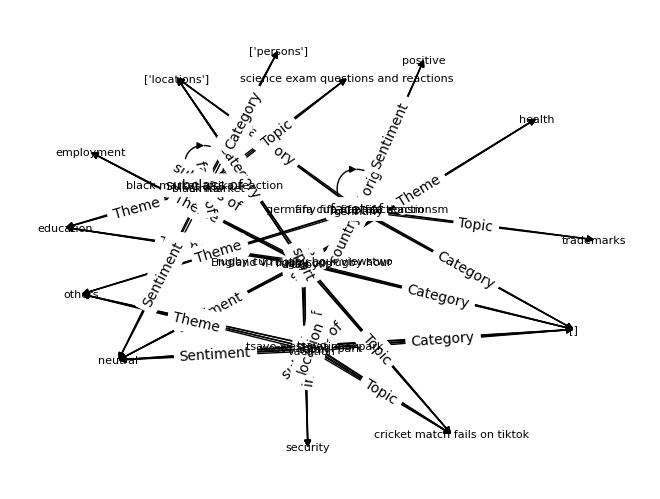

In [89]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate modularity of the entire graph
modularity = nx.community.modularity(nx.DiGraph(G), [G.nodes], weight='weight')

# Assign modularity as weight to each node
for node in G.nodes:
    G.nodes[node]['weight'] = modularity

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')

# Draw nodes with sizes based on modularity
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Manual label positioning to disperse them
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


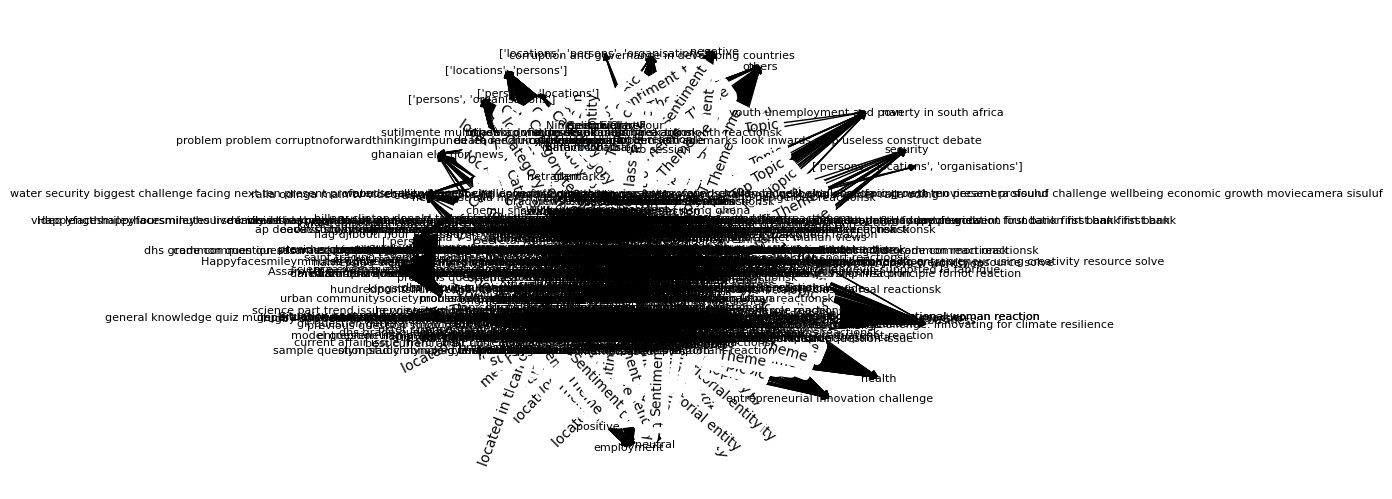

In [90]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate modularity of the entire graph
modularity = nx.community.modularity(nx.DiGraph(G), [G.nodes], weight='weight')

# Assign modularity as weight to each node
for node in G.nodes:
    G.nodes[node]['weight'] = modularity

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')

# Draw nodes with sizes based on modularity
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Manual label positioning to disperse them
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


In [91]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt

# # Assuming your data is stored in a DataFrame named 'df2'
# # Extract relevant columns (without 'cluster')
# df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges to the graph
# for _, row in df_subset.iterrows():
#     topic = row['topic']
#     sentiment = row['sentiment']
#     relations = ast.literal_eval(row['Relations'])
#     category = row['category']
#     theme = row['theme']
#     entities = [row['Head'], row['Tail']]
#     time = row['Date']

#     # Add nodes with time information
#     G.add_node(topic, type='Topic', time=time)
#     G.add_node(sentiment, type='Sentiment', time=time)
#     G.add_node(theme, type='Theme', time=time)
#     G.add_node(category, type='Category', time=time)

#     for entity in entities:
#         G.add_node(entity, type='Entity', time=time)

#     # Add edges from Relations with time information
#     for relation in relations:
#         head = relation['head']
#         relation_type = relation['type']
#         tail = relation['tail']
#         G.add_edge(head, tail, type=relation_type, time=time)

#         # Add additional edges for relationships between head/tail and other components
#         G.add_edge(head, sentiment, type='Sentiment', time=time)
#         G.add_edge(head, theme, type='Theme', time=time)
#         G.add_edge(head, category, type='Category', time=time)
#         G.add_edge(head, topic, type='Topic', time=time)

#         G.add_edge(tail, sentiment, type='Sentiment', time=time)
#         G.add_edge(tail, theme, type='Theme', time=time)
#         G.add_edge(tail, category, type='Category', time=time)
#         G.add_edge(tail, topic, type='Topic', time=time)

# # Calculate PageRank for each node
# pagerank = nx.pagerank(G)

# # Assign PageRank score as weight to each node
# for node, score in pagerank.items():
#     G.nodes[node]['weight'] = score

# # Compute layout for plotting
# pos = nx.spring_layout(G)

# # Get the node weights and ensure they are aligned with the nodes in G
# node_weights = [pagerank[node] * 1000 for node in G.nodes()]
# node_colors = [pagerank[node] for node in G.nodes()]

# # Draw nodes with sizes based on PageRank score
# nx.draw(G, pos, with_labels=False, node_size=node_weights, node_color=node_colors, cmap=plt.cm.rainbow)

# # Function to adjust label positions to avoid overlap
# def adjust_label_position(x, y, offset=0.09):
#     """Applies a small random offset to avoid label overlap."""
#     return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# # Place labels at adjusted positions
# for node, (x, y) in pos.items():
#     new_x, new_y = adjust_label_position(x, y)  # Adjust label positions to avoid overlap
#     plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# # Do not draw edge labels
# plt.show()


In [92]:
df_people['sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

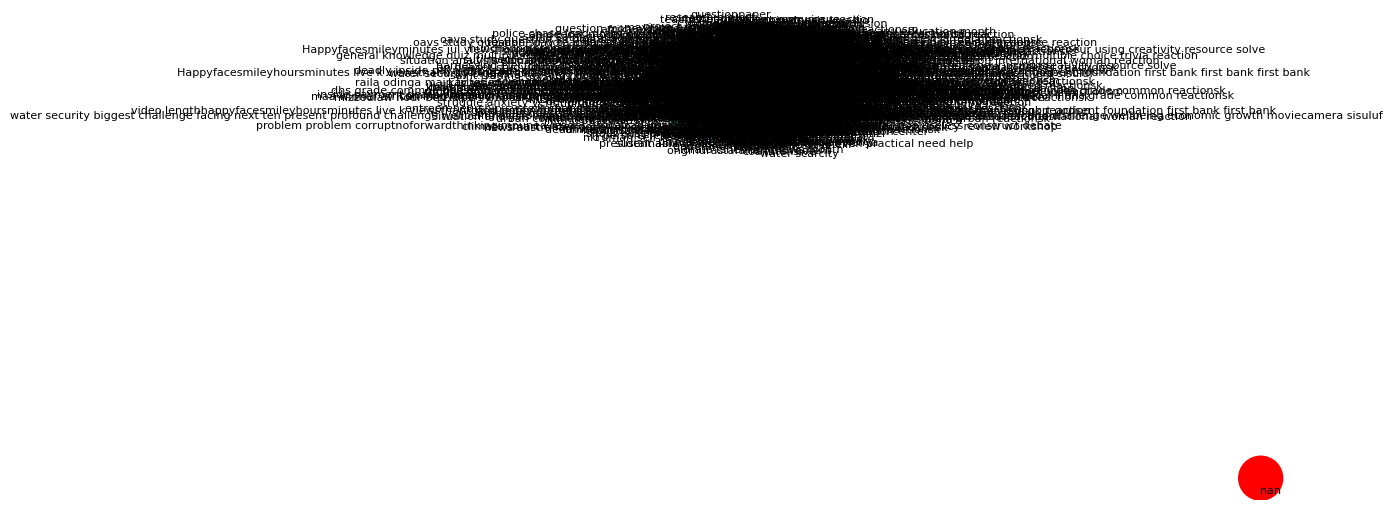

In [93]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # For Louvain method
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns (without 'cluster')
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Detect communities using Louvain method on the undirected graph
partition = community_louvain.best_partition(G_undirected)

# Assign modularity class as 'weight' for each node (color-coding by community)
for node, community in partition.items():
    G_undirected.nodes[node]['weight'] = community

# Compute layout for plotting
pos = nx.spring_layout(G_undirected)

# Get node colors based on community assignment (modularity)
node_colors = [partition[node] for node in G_undirected.nodes()]
node_weights = [1000 for _ in G_undirected.nodes()]  # Uniform node size, adjust as needed

# Draw the graph with modularity-based colors
nx.draw(G_undirected, pos, with_labels=False, node_size=node_weights, node_color=node_colors, cmap=plt.cm.rainbow)

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.09):
    """Applies a small random offset to avoid label overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Place labels at adjusted positions
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label positions to avoid overlap
    plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# Do not draw edge labels
plt.show()
# Save the graph in GEXF format
nx.write_gexf(G_undirected, 'graph_modularity2.gexf')


In [94]:
s= df_people['topic'].unique()
s

array(['hacking for business', 'science exam questions and reactions',
       'ghanaian election news', 'trademarks',
       'entrepreneurial innovation challenge',
       'water & environmental challenge: innovating for climate resilience',
       'cricket match fails on tiktok',
       'youth unemployment and poverty in south africa',
       'corruption and governance in developing countries'], dtype=object)

In [95]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # For Louvain method
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns (without 'cluster')
df_subset = df_people[df_people['topic'] == 'justice and distributive problems'][['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Detect communities using Louvain method on the undirected graph
partition = community_louvain.best_partition(G_undirected)

# Assign modularity class as 'community' for each node
for node, community in partition.items():
    G_undirected.nodes[node]['community'] = community

# Save the entire graph with community information to a GEXF file (suitable for Gephi)
nx.write_gexf(G_undirected, "graph_with_communities2.gexf")

# Optionally, save as GraphML if needed
# nx.write_graphml(G_undirected, "graph_with_communities.graphml")


In [96]:
# Sort nodes by their community and return the top 10 nodes
top_10_nodes = sorted(partition, key=lambda node: partition[node], reverse=True)[:10]

print("Top 10 nodes by community modularity:")
for node in top_10_nodes:
    print(f"Node: {node}, Community: {partition[node]}")


Top 10 nodes by community modularity:


In [170]:
import ast
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import community as community_louvain  # For Louvain method

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns (without 'cluster')
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Step 1: Convert NetworkX graph to PyTorch Geometric format

# Get all unique nodes and label encode them
all_nodes = list(G_undirected.nodes)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids = node_encoder.transform(all_nodes)

# Create edge index (source and target nodes for each edge)
edge_index = []
for source, target in G_undirected.edges():
    edge_index.append([node_encoder.transform([source])[0], node_encoder.transform([target])[0]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Use dummy node features (all ones)
num_nodes = len(G_undirected.nodes())
x = torch.ones((num_nodes, 1), dtype=torch.float)  # Feature matrix with a single feature (dummy features)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Step 2: Define a simple Graph Convolutional Network (GCN)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GCN(num_features=1, hidden_channels=16, num_classes=16)

# Step 3: Train the GCN model (example with random training for simplicity)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.ones(out.shape))  # Dummy loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Step 4: Extract node embeddings from the trained model
model.eval()
with torch.no_grad():
    embeddings = model(data)

# Now 'embeddings' contains the GNN embeddings for each node
print("Node embeddings:")
print(embeddings)

# Step 5: Detect communities using Louvain method on the node embeddings

# Use Louvain method for community detection, based on embeddings
node_community = community_louvain.best_partition(G_undirected)

# Step 6: Assign community as 'community' attribute to each node
for node, community in node_community.items():
    G_undirected.nodes[node]['community'] = community

# Step 7: Save the graph with community information to a GEXF file (for Gephi visualization)
nx.write_gexf(G_undirected, "graph_with_communities_gnn_embeddings.gexf")

# Optionally, save as GraphML if needed
# nx.write_graphml(G_undirected, "graph_with_communities_gnn_embeddings.graphml")


Epoch 0, Loss: 1.2733075618743896
Epoch 10, Loss: 0.31296542286872864
Epoch 20, Loss: 0.059539444744586945
Epoch 30, Loss: 0.01865192875266075
Epoch 40, Loss: 0.01851116679608822
Epoch 50, Loss: 0.010923213325440884
Epoch 60, Loss: 0.010273093357682228
Epoch 70, Loss: 0.009609493426978588
Epoch 80, Loss: 0.009203433059155941
Epoch 90, Loss: 0.009022201411426067
Node embeddings:
tensor([[1.0224, 1.0262, 1.0191,  ..., 1.0168, 1.0178, 1.0204],
        [0.7859, 0.7609, 0.7911,  ..., 0.8071, 0.7812, 0.8073],
        [0.7790, 0.7531, 0.7849,  ..., 0.8004, 0.7745, 0.8012],
        ...,
        [1.0739, 1.0878, 1.0624,  ..., 1.0708, 1.0685, 1.0666],
        [1.0602, 1.0753, 1.0630,  ..., 1.0463, 1.0628, 1.0630],
        [1.0158, 1.0256, 1.0161,  ..., 1.0111, 1.0166, 1.0211]])


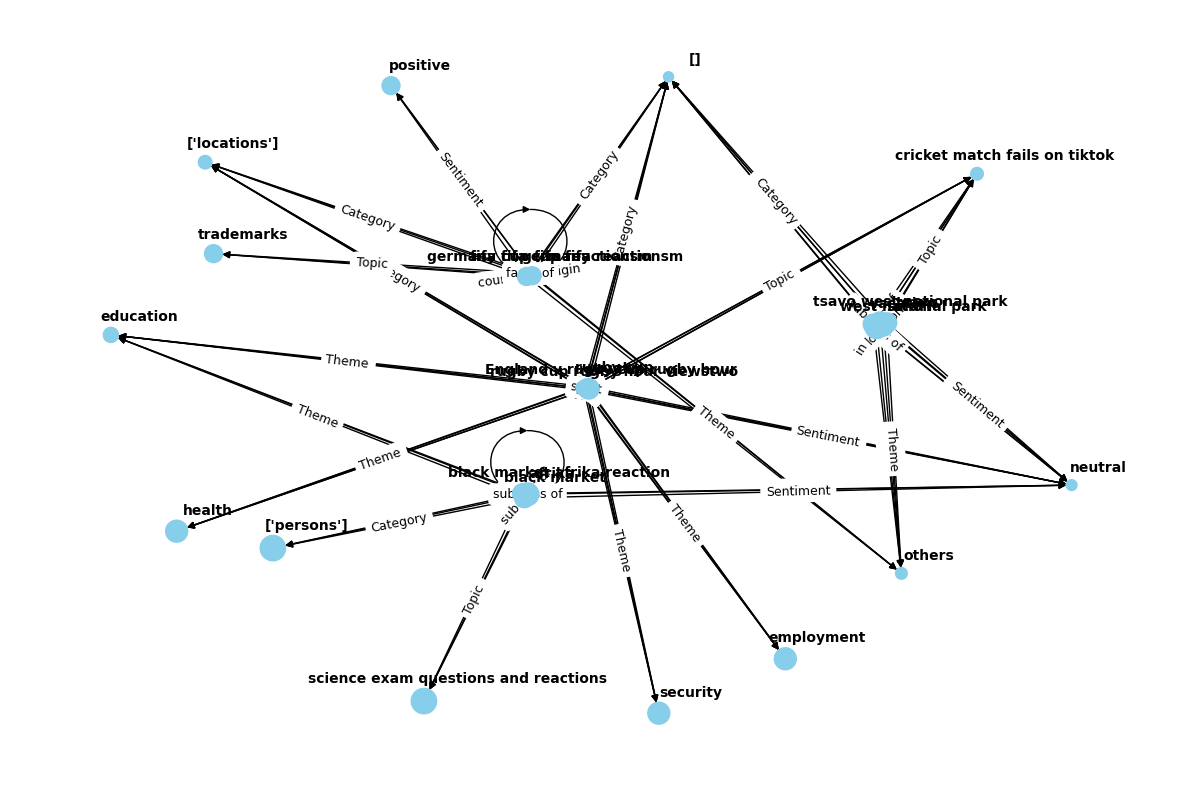

In [98]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns, removing 'cluster'
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'Date' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Assign clustering coefficient as weight to each node
for node, coefficient in clustering_coefficients.items():
    G.nodes[node]['weight'] = coefficient

# Compute layout for plotting
pos = nx.spring_layout(G)

# Compute node sizes based on clustering coefficient
node_weights = nx.get_node_attributes(G, 'weight')

# Draw the graph
fig, ax = plt.subplots(figsize=(15, 10))

# Draw nodes with sizes based on clustering coefficient
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black', ax=ax)

# Manual label positioning to avoid overlap by slightly offsetting the labels
for node, (x, y) in pos.items():
    # Offset labels for clearer visibility
    offset = 0.05 * (node_weights.get(node, 1) + 1)  # Adjust offset based on node size
    plt.text(x + offset, y + offset, node, fontsize=10, ha='center', va='center', fontweight='bold')

# Draw edge labels
labels = nx.get_edge_attributes(G, 'type')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=9)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()


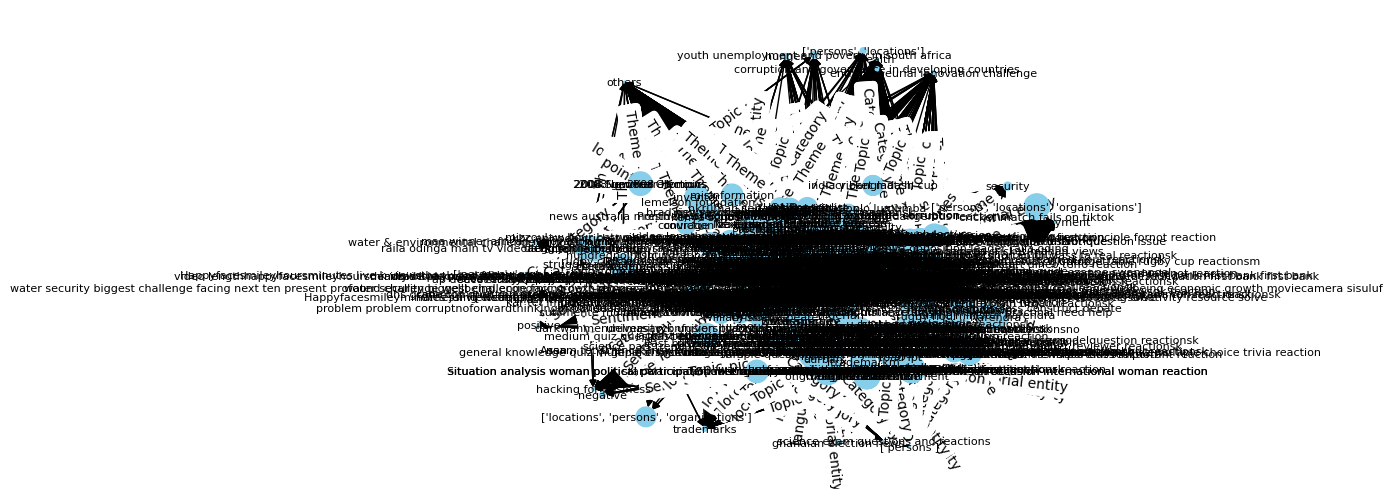

In [99]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
#df_subset = df_education[['topic', 'theme', 'cluster', 'Head', 'Tail', 'sentiment', 'Relations', 'category']]
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Assign clustering coefficient as weight to each node
for node, coefficient in clustering_coefficients.items():
    G.nodes[node]['weight'] = coefficient

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')

# Draw nodes with sizes based on clustering coefficient
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Manual label positioning to disperse them
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


In [100]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Sort nodes based on clustering coefficient
top_nodes_by_clustering_coefficient = sorted(clustering_coefficients, key=clustering_coefficients.get, reverse=True)[:10]

print("Top ten nodes by clustering coefficient:")
for node in top_nodes_by_clustering_coefficient:
    print(f"Node: {node}")


Top ten nodes by clustering coefficient:
Node: tedx talk speech
Node: sean stephenson
Node: viewspresident
Node: durban
Node: political participation
Node: golf
Node: past question answer mark
Node: month reactionsk
Node: sigi regency
Node: sigi


In [101]:
df2=df_people.tail(10)

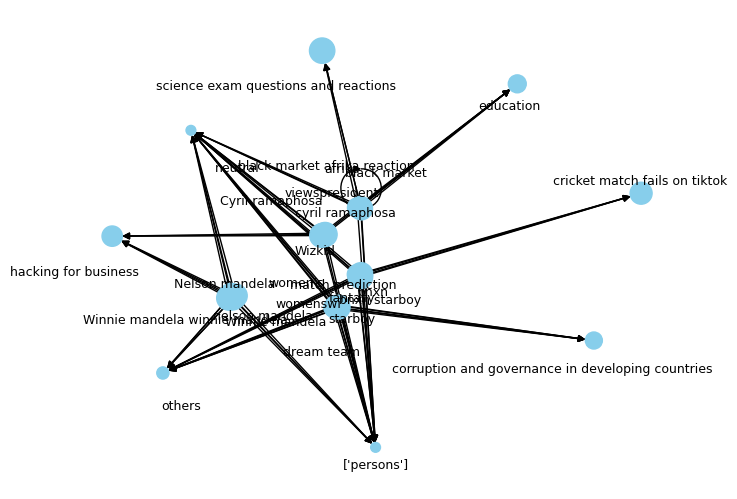

In [102]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Assign clustering coefficient as weight to each node
for node, coefficient in clustering_coefficients.items():
    G.nodes[node]['weight'] = coefficient

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on clustering coefficient
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# To avoid label overlap, we introduce a random offset for each label
def adjust_label_position(x, y, offset=0.2):
    """Adjusts the position of labels to avoid overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Manual label positioning with random offsets to disperse them
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label position to avoid overlap
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# No edge labels
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Display the plot
plt.show()


In [103]:
#df2=df_education.head(1)
#df2.columns

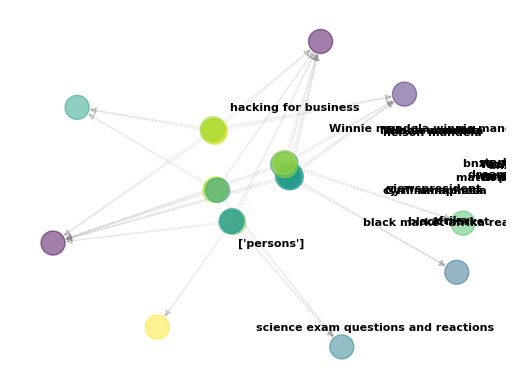

In [104]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Compute clustering coefficients for each node
clustering_coefficients = nx.clustering(G)

# Assign colors based on clustering coefficients
node_colors = {}
for node, cc in clustering_coefficients.items():
    # Round to 2 decimal places and scale to range [0, 1]
    color_value = round(cc, 2)
    node_colors[node] = color_value

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=pos, node_color=[node_colors[node] for node in G.nodes()], alpha=0.5)

# Draw edges
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

# Expand labels to avoid overlap by adding slight offset
label_pos = {node: (x + 1, y + 0.001) for node, (x, y) in pos.items()}

# Draw node labels with adjusted positions
nx.draw_networkx_labels(G, label_pos, font_size=8, font_color='black', font_weight='bold')

# Hide axis
plt.axis('off')

# Watermark
plt.text(0.99, 0.01, ' ',
         verticalalignment='bottom',
         horizontalalignment='right',
         transform=plt.gca().transAxes,
         color='grey',
         fontsize=15,
         alpha=0.9)

# Show the plot
plt.show()


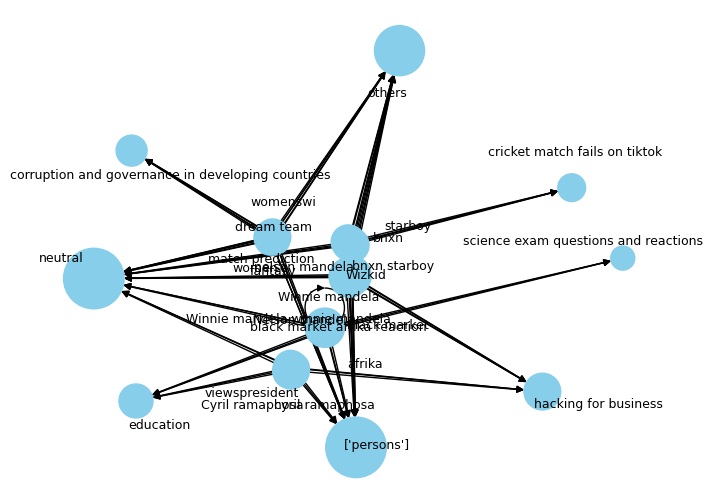

In [105]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Use **degree** instead of clustering coefficient for node weights
node_degrees = dict(G.degree())

# Assign degree as weight to each node
for node, degree in node_degrees.items():
    G.nodes[node]['weight'] = degree

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node degree
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 100 for v in node_weights.values()], node_color='skyblue', font_color='black')

# To avoid label overlap, we introduce a random offset for each label
def adjust_label_position(x, y, offset=0.2):
    """Adjusts the position of labels to avoid overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Manual label positioning with random offsets to disperse them
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label position to avoid overlap
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# No edge labels
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Display the plot
plt.show()


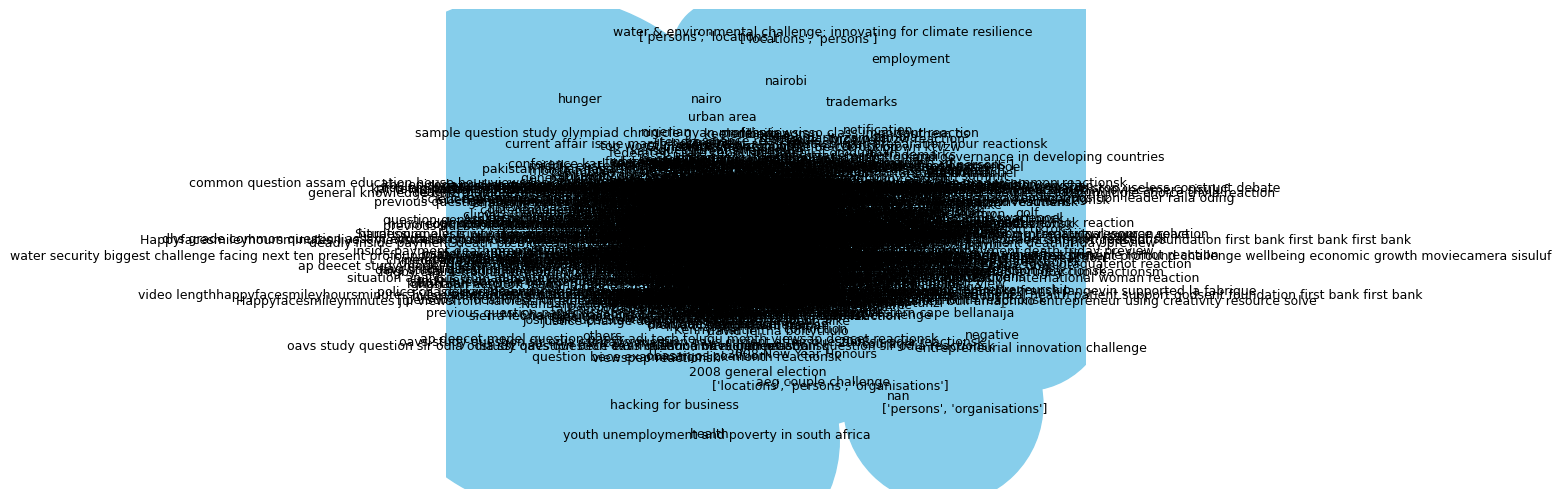

In [106]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Use **degree** instead of clustering coefficient for node weights
node_degrees = dict(G.degree())

# Assign degree as weight to each node
for node, degree in node_degrees.items():
    G.nodes[node]['weight'] = degree

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node degree
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 100 for v in node_weights.values()], node_color='skyblue', font_color='black')

# To avoid label overlap, we introduce a random offset for each label
def adjust_label_position(x, y, offset=0.2):
    """Adjusts the position of labels to avoid overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Manual label positioning with random offsets to disperse them
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label position to avoid overlap
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# No edge labels
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Display the plot
plt.show()


In [107]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate degree for each node
node_degrees = dict(G.degree())

# Sort nodes based on degree
top_nodes_by_degree = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]

print("Top ten nodes by degree:")
for node in top_nodes_by_degree:
    print(f"Node: {node}, Degree: {node_degrees[node]}")


Top ten nodes by degree:
Node: neutral, Degree: 1118
Node: ['persons'], Degree: 1095
Node: others, Degree: 652
Node: science exam questions and reactions, Degree: 581
Node: poverty, Degree: 491
Node: health, Degree: 347
Node: employment, Degree: 298
Node: education, Degree: 283
Node: hacking for business, Degree: 258
Node: ['persons', 'organisations'], Degree: 206


## Influence- centrality

In [108]:
df2=df_people.head(50)

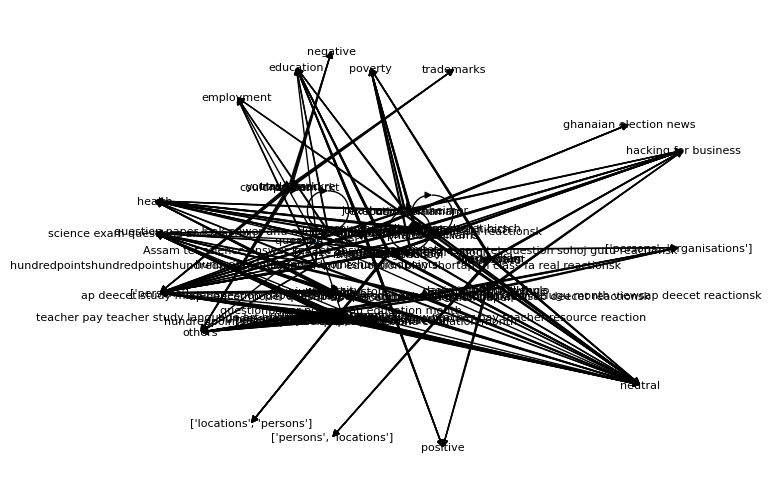

In [109]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)
        
# Calculate betweenness centrality for nodes
node_betweenness_centrality = nx.betweenness_centrality(G)

# Set node weights based on betweenness centrality
for node, centrality in node_betweenness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Draw the graph
pos = nx.spring_layout(G)
# To avoid label overlap, we introduce a random offset for each label
def adjust_label_position(x, y, offset=0.8):
    """Adjusts the position of labels to avoid overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Draw nodes with sizes based on node weights
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Manual label positioning to disperse them
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Remove this line to avoid displaying edge labels
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


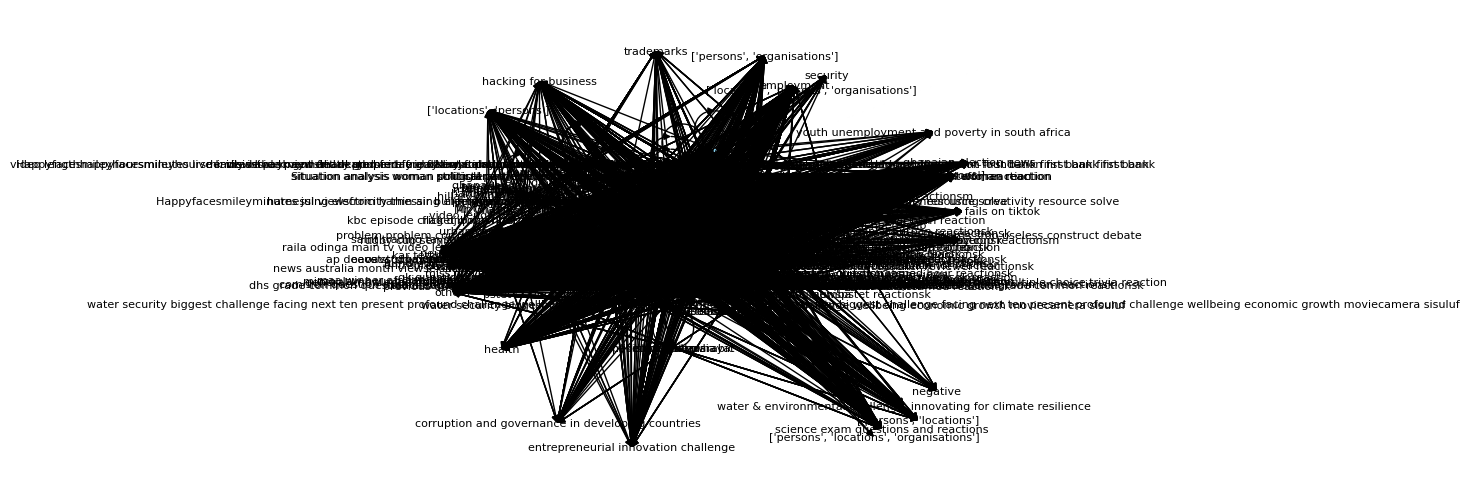

In [110]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()
# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)
        
# Calculate betweenness centrality for nodes
node_betweenness_centrality = nx.betweenness_centrality(G)

# Set node weights based on betweenness centrality
for node, centrality in node_betweenness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Draw the graph
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Manual label positioning to disperse them
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Remove this line to avoid displaying edge labels
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


In [111]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate betweenness centrality for each node
betweenness_centralities = nx.betweenness_centrality(G)

# Sort nodes based on betweenness centrality
top_nodes_by_betweenness_centrality = sorted(betweenness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by betweenness centrality:")
for node, centrality in top_nodes_by_betweenness_centrality:
    print(f"Node: {node}")


Top ten nodes by betweenness centrality:
Node: poverty
Node: education
Node: reactionsk
Node: Nigeria
Node: business
Node: entrepreneurship
Node: president
Node: Entrepreneur
Node: President
Node: science


Graph exported successfully to graph_output_betweenness.gexf


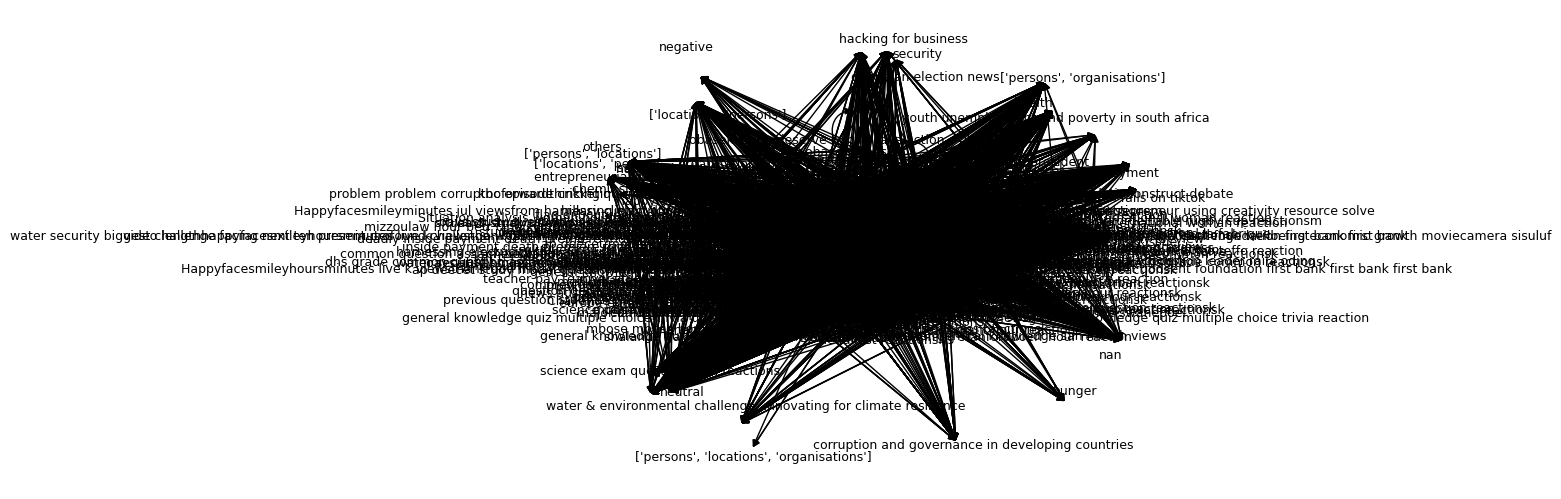

In [112]:
import ast
import networkx as nx
import random
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate betweenness centrality for nodes
node_betweenness_centrality = nx.betweenness_centrality(G)

# Set node weights based on betweenness centrality
for node, centrality in node_betweenness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Export the graph to GEXF for Gephi
nx.write_gexf(G, "graph_output_betweenness.gexf")

# You can also use GraphML format if you prefer
# nx.write_graphml(G, "graph_output_betweenness.graphml")

print("Graph exported successfully to graph_output_betweenness.gexf")

# Optional: Visualization using matplotlib
# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights (betweenness centrality)
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.15):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


Top 20 most influential nodes based on betweenness centrality:
Node: ['persons'], Betweenness Centrality: 0.3280209491456382
Node: neutral, Betweenness Centrality: 0.32772495724404543
Node: others, Betweenness Centrality: 0.10965861786376584
Node: science exam questions and reactions, Betweenness Centrality: 0.0631735318223815
Node: poverty, Betweenness Centrality: 0.06047545356759138
Node: education, Betweenness Centrality: 0.027653457247319987
Node: employment, Betweenness Centrality: 0.02288659862573717
Node: health, Betweenness Centrality: 0.020535815235151047
Node: ['persons', 'organisations'], Betweenness Centrality: 0.015593037085429898
Node: hacking for business, Betweenness Centrality: 0.012799301601941006
Node: positive, Betweenness Centrality: 0.011329703795636026
Node: ['locations', 'persons'], Betweenness Centrality: 0.006172711830012588
Node: entrepreneurial innovation challenge, Betweenness Centrality: 0.00569060719690222
Node: ghanaian election news, Betweenness Central

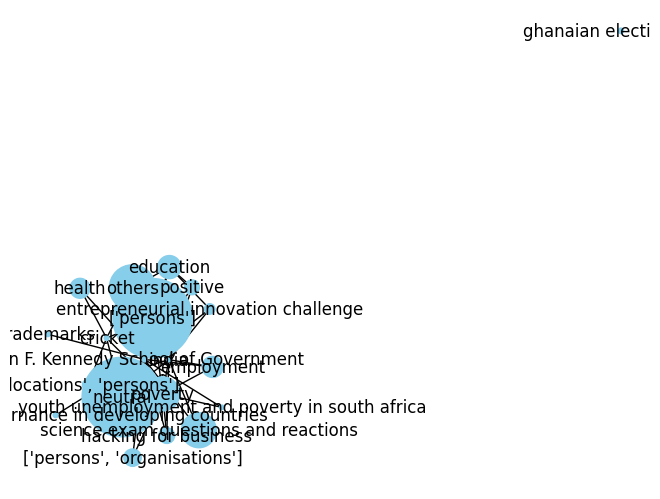

In [144]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns (without 'cluster')
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Calculate betweenness centrality for each node to determine influence
betweenness_centrality = nx.betweenness_centrality(G_undirected)

# Assign betweenness centrality as 'influence' for each node
for node, centrality in betweenness_centrality.items():
    G_undirected.nodes[node]['influence'] = centrality

# Save the entire graph with betweenness centrality information to a GEXF file (suitable for Gephi)
nx.write_gexf(G_undirected, "graph_with_betweenness_influence_1k2.gexf")

# Optionally, save as GraphML if needed
# nx.write_graphml(G_undirected, "graph_with_betweenness_influence.graphml")

# Optionally, display the top 20 most influential nodes by betweenness centrality
top_20_influential_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:20]

print("Top 20 most influential nodes based on betweenness centrality:")
for node in top_20_influential_nodes:
    print(f"Node: {node}, Betweenness Centrality: {betweenness_centrality[node]}")

# If you want to visualize the top 20 influential nodes:
subgraph = G_undirected.subgraph(top_20_influential_nodes)

# Compute layout for plotting
pos = nx.spring_layout(subgraph)

# Draw the graph with node size based on betweenness centrality
node_sizes = [betweenness_centrality[node] * 10000 for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_size=node_sizes, node_color='skyblue')

# Show the plot
plt.show()


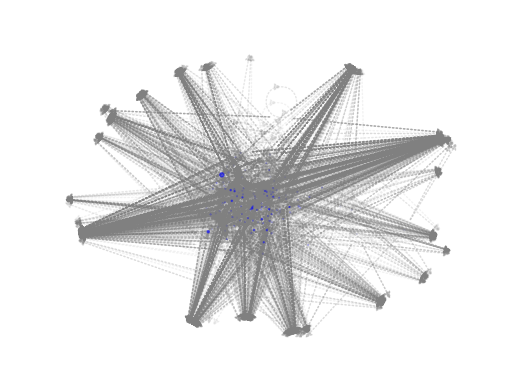

In [114]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Compute betweenness centrality for each node
betweenness_centrality = nx.betweenness_centrality(G)

# Assign node sizes based on betweenness centrality
node_sizes = [5000 * betweenness_centrality[node] for node in G.nodes()]

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=pos, node_size=node_sizes, node_color='blue', alpha=0.5)

# Draw edges
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

plt.axis('off')

# Watermark
plt.text(0.99, 0.01, ' ',
         verticalalignment='bottom',
         horizontalalignment='right',
         transform=plt.gca().transAxes,
         color='grey',
         fontsize=15,
         alpha=0.9)

# Show the plot
plt.show()


In [115]:
df2=df_expanded.tail(20)

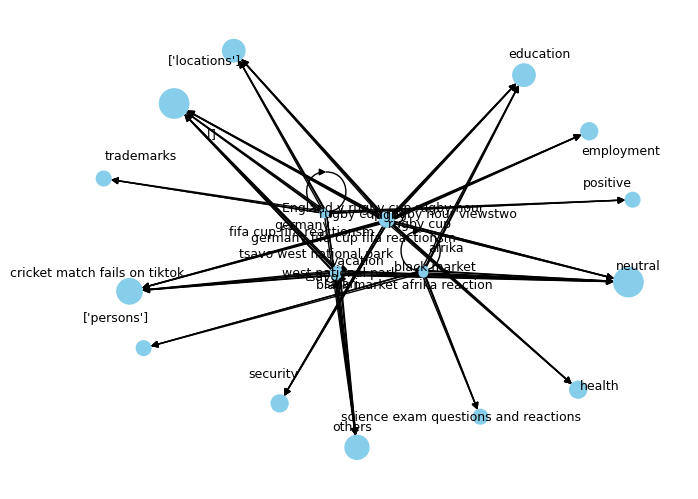

In [116]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate closeness centrality for nodes
node_closeness_centrality = nx.closeness_centrality(G)

# Set node weights based on closeness centrality
for node, centrality in node_closeness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.15):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


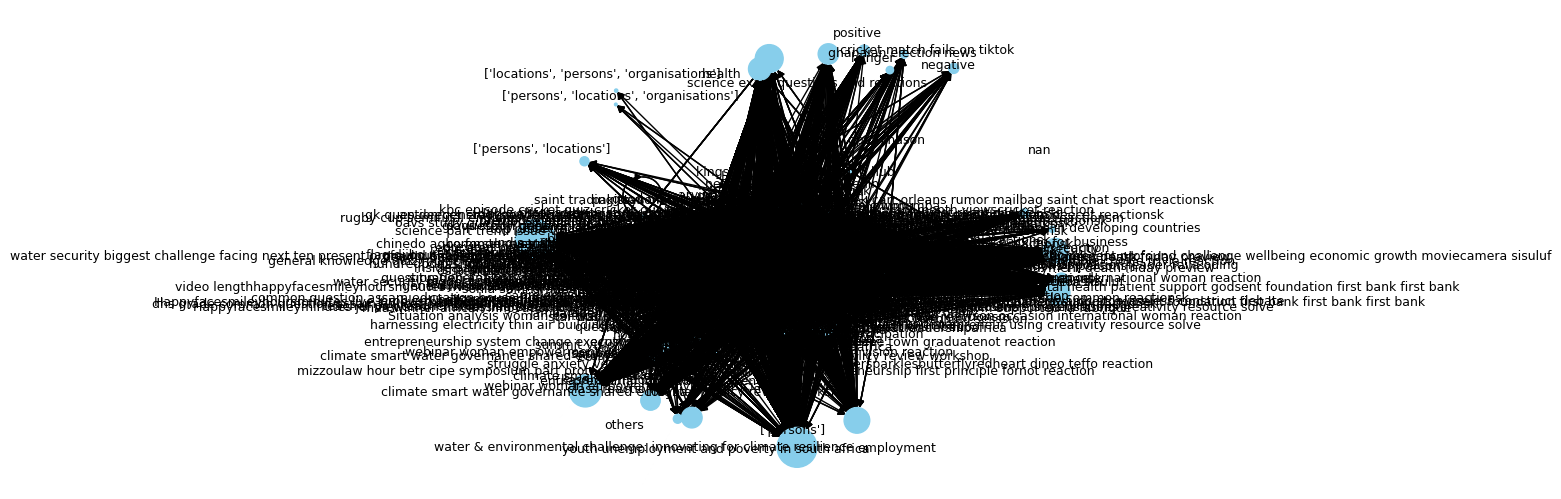

In [117]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate closeness centrality for nodes
node_closeness_centrality = nx.closeness_centrality(G)

# Set node weights based on closeness centrality
for node, centrality in node_closeness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.15):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


In [118]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate closeness centrality for each node
closeness_centralities = nx.closeness_centrality(G)

# Sort nodes based on closeness centrality
top_nodes_by_closeness_centrality = sorted(closeness_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by closeness centrality:")
for node, centrality in top_nodes_by_closeness_centrality:
    print(f"Node: {node}")


Top ten nodes by closeness centrality:
Node: neutral
Node: ['persons']
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: hacking for business
Node: ['persons', 'organisations']
Node: health
Node: youth unemployment and poverty in south africa


Graph exported successfully to graph_output_closeness.gexf


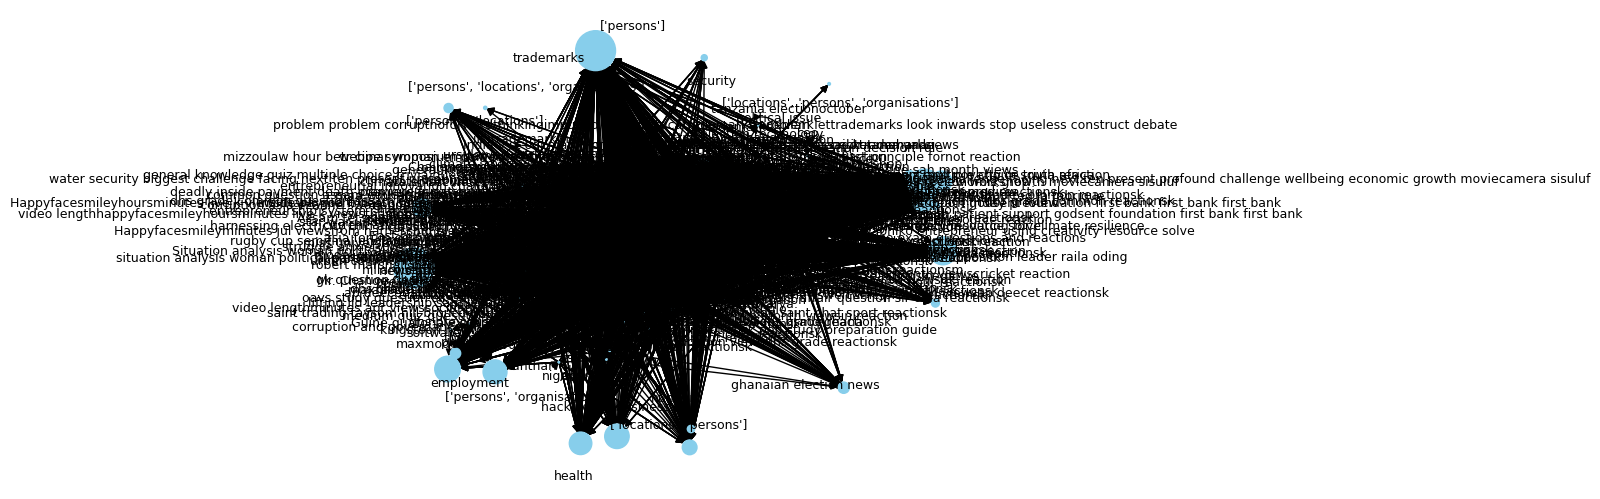

In [119]:
import ast
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate closeness centrality for nodes
node_closeness_centrality = nx.closeness_centrality(G)

# Set node weights based on closeness centrality
for node, centrality in node_closeness_centrality.items():
    G.nodes[node]['weight'] = centrality

# Export the graph to GEXF for Gephi
nx.write_gexf(G, "graph_output_closeness.gexf")

# You can also use GraphML format if you prefer
# nx.write_graphml(G, "graph_output_closeness.graphml")

print("Graph exported successfully to graph_output_closeness.gexf")

# If you still want to visualize it in matplotlib
# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights (closeness centrality)
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.15):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


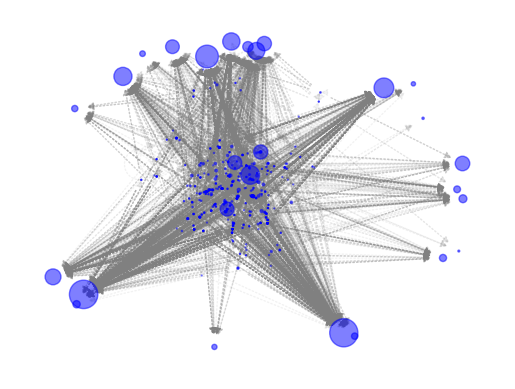

In [120]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Compute closeness centrality for each node
closeness_centrality = nx.closeness_centrality(G)

# Assign node sizes based on closeness centrality
node_sizes = [500 * closeness_centrality[node] for node in G.nodes()]

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=pos, node_size=node_sizes, node_color='blue', alpha=0.5)

# Draw edges
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

plt.axis('off')

# Watermark
plt.text(0.99, 0.01, ' ',
         verticalalignment='bottom',
         horizontalalignment='right',
         transform=plt.gca().transAxes,
         color='grey',
         fontsize=15,
         alpha=0.9)

# Show the plot
plt.show()


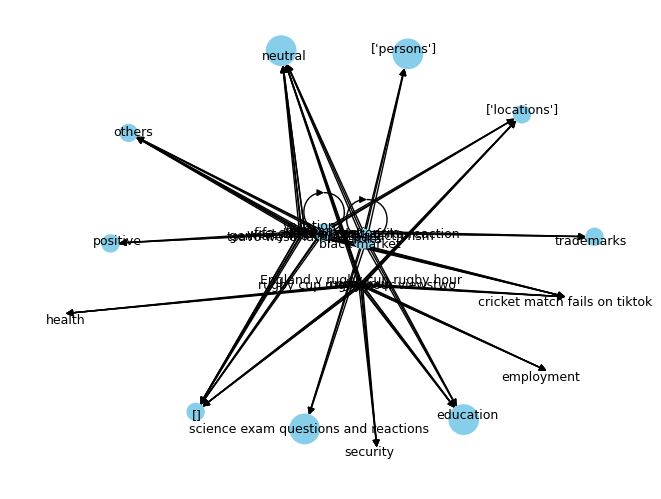

In [121]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns (removed 'cluster')
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate eigenvector centrality for nodes
node_eigenvector_centrality = nx.eigenvector_centrality(G)

# Set node weights based on eigenvector centrality
for node, centrality in node_eigenvector_centrality.items():
    G.nodes[node]['weight'] = centrality

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights (multiplied for visibility)
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.03):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset to disperse labels
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


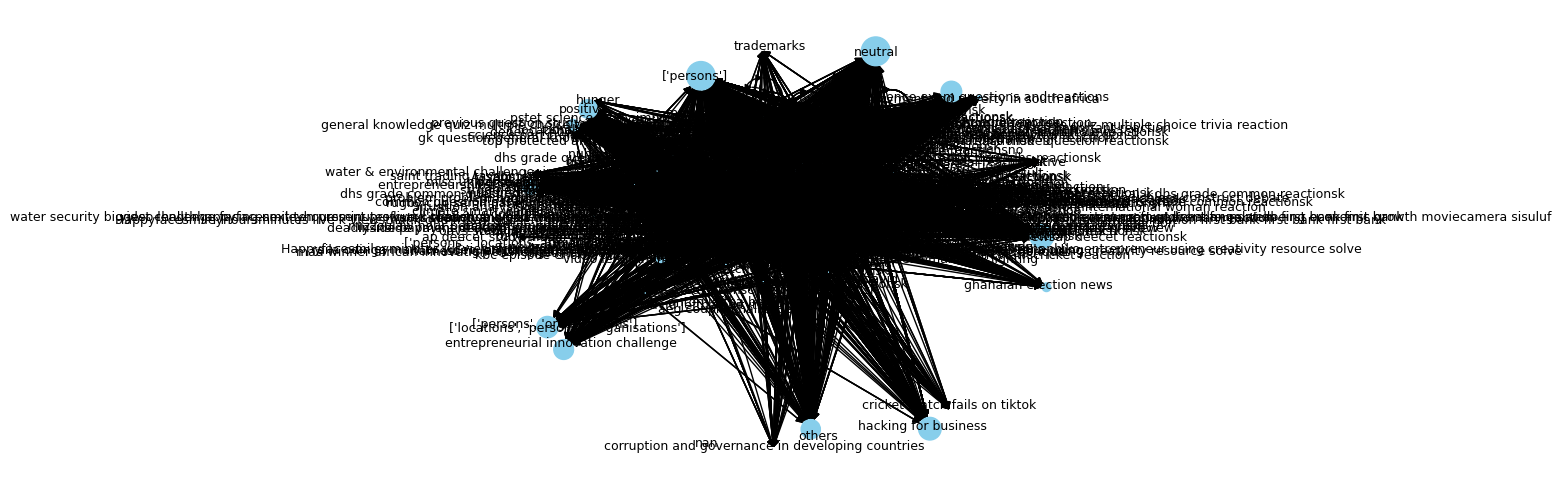

In [122]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns (removed 'cluster')
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate eigenvector centrality for nodes
node_eigenvector_centrality = nx.eigenvector_centrality(G)

# Set node weights based on eigenvector centrality
for node, centrality in node_eigenvector_centrality.items():
    G.nodes[node]['weight'] = centrality

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on node weights (multiplied for visibility)
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.03):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Adjust labels for better positioning and to avoid overlap
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Apply random offset to disperse labels
    plt.text(new_x, new_y, node, fontsize=9, ha='center', va='center')

# Display the plot without edge labels
plt.show()


In [123]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate eigenvector centrality for each node
eigenvector_centralities = nx.eigenvector_centrality(G)

# Sort nodes based on eigenvector centrality
top_nodes_by_eigenvector_centrality = sorted(eigenvector_centralities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by eigenvector centrality:")
for node, centrality in top_nodes_by_eigenvector_centrality:
    print(f"Node: {node}")


Top ten nodes by eigenvector centrality:
Node: neutral
Node: ['persons']
Node: poverty
Node: employment
Node: hacking for business
Node: ['persons', 'organisations']
Node: youth unemployment and poverty in south africa
Node: entrepreneurial innovation challenge
Node: others
Node: positive


In [124]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd  # Import pandas for data manipulation

# # Assuming your data is stored in a DataFrame named 'df2'
# # Extract relevant columns
# df_subset = df_people[['topic', 'Date', 'theme', 'cluster', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges to the graph
# for _, row in df_subset.iterrows():
#     topic = row['topic']
#     sentiment = row['sentiment']
#     relations = ast.literal_eval(row['Relations'])
#     category = row['category']  # Assuming category is a list
#     theme = row['theme']
#     cluster = row['cluster']
#     entities = [row['Head'], row['Tail']]  # Corrected entities extraction
#     time = row['Date']  # Assuming there is a 'time' column in your DataFrame

#     # Add nodes with time information
#     G.add_node(topic, type='Topic', time=time)
#     G.add_node(sentiment, type='Sentiment', time=time)
#     G.add_node(theme, type='Theme', time=time)
#     G.add_node(category, type='Category', time=time)
#     G.add_node(cluster, type='Cluster', time=time)
    
#     for entity in entities:
#         G.add_node(entity, type='Entity', time=time)

#     # Add edges from Relations with time and views information
#     for relation in relations:
#         head = relation['head']
#         relation_type = relation['type']
#         tail = relation['tail']
#         G.add_edge(head, tail, type=relation_type, time=time)

#         # Add additional edges for relationships between head/tail and other components
#         G.add_edge(head, sentiment, type='Sentiment', time=time)
#         G.add_edge(head, theme, type='Theme', time=time)
#         G.add_edge(head, category, type='Category', time=time)
#         G.add_edge(head, cluster, type='Cluster', time=time)
#         G.add_edge(head, topic, type='Topic', time=time)

#         G.add_edge(tail, sentiment, type='Sentiment', time=time)
#         G.add_edge(tail, theme, type='Theme', time=time)
#         G.add_edge(tail, category, type='Category', time=time)
#         G.add_edge(tail, cluster, type='Cluster', time=time)
#         G.add_edge(tail, topic, type='Topic', time=time)

# # Compute Eigenvector centrality for each node
# eigenvector_centrality = nx.eigenvector_centrality(G)

# # Assign node sizes based on Eigenvector centrality
# node_sizes = [500 * eigenvector_centrality[node] for node in G.nodes()]

# # Save the graph in GEXF file format
# nx.write_gexf(G, 'graphgcn2.gexf')

# # Compute layout for plotting
# pos = nx.spring_layout(G)

# # Draw nodes
# nx.draw_networkx_nodes(G=G, pos=pos, node_size=node_sizes, node_color='blue', alpha=0.5)

# # Draw edges
# nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

# plt.axis('off')

# # Watermark
# plt.text(0.99, 0.01, ' ',
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          transform=plt.gca().transAxes,
#          color='grey',
#          fontsize=15,
#          alpha=0.9)

# # Show the plot
# plt.show()


## link analysis

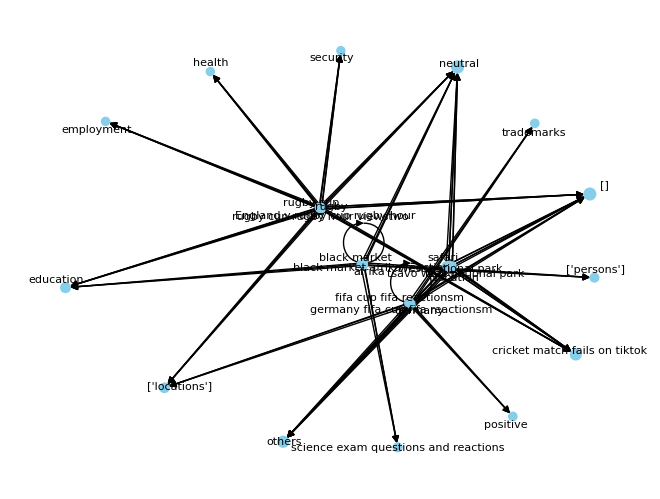

In [125]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate PageRank for each node
pagerank = nx.pagerank(G)

# Assign PageRank score as weight to each node
for node, score in pagerank.items():
    G.nodes[node]['weight'] = score

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on PageRank score
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Adjust label positions to avoid overlapping by adding random offsets
def adjust_label_position(x, y, offset=0.05):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Place labels at adjusted positions to avoid overlapping
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust the position to avoid overlap
    plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# Do not draw edge labels
# plt.show() will display the graph without link labels
plt.show()


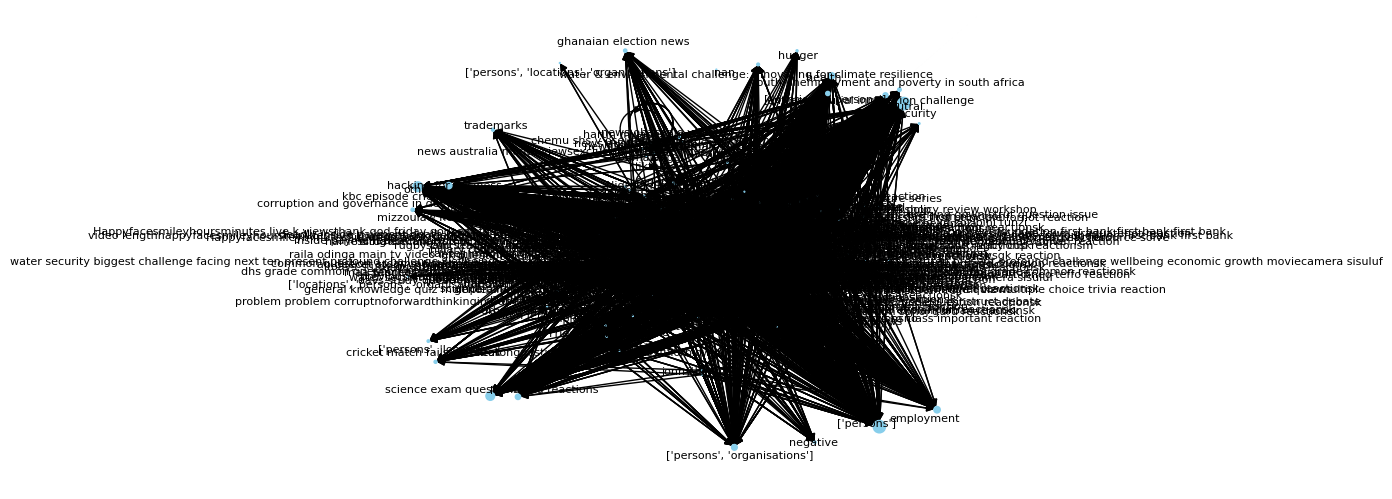

In [126]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate PageRank for each node
pagerank = nx.pagerank(G)

# Assign PageRank score as weight to each node
for node, score in pagerank.items():
    G.nodes[node]['weight'] = score

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on PageRank score
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Adjust label positions to avoid overlapping by adding random offsets
def adjust_label_position(x, y, offset=0.05):
    """Apply small random offset to the label position to avoid overlapping."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Place labels at adjusted positions to avoid overlapping
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust the position to avoid overlap
    plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# Do not draw edge labels
# plt.show() will display the graph without link labels
plt.show()


In [127]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate PageRank for each node
pageranks = nx.pagerank(G)

# Sort nodes based on PageRank
top_nodes_by_pagerank = sorted(pageranks.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by PageRank:")
for node, rank in top_nodes_by_pagerank:
    print(f"Node: {node}")


Top ten nodes by PageRank:
Node: ['persons']
Node: neutral
Node: others
Node: science exam questions and reactions
Node: poverty
Node: employment
Node: hacking for business
Node: health
Node: ['persons', 'organisations']
Node: education


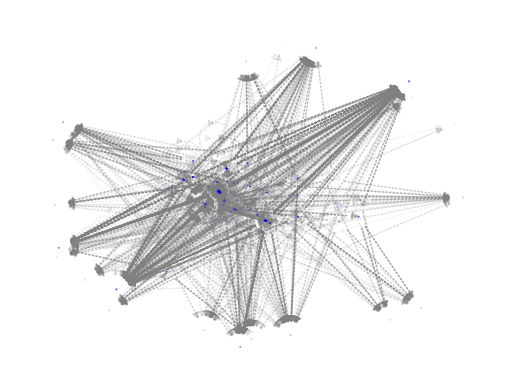

In [128]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_education[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Compute PageRank centrality for each node
pagerank_centrality = nx.pagerank(G)

# Assign node sizes based on PageRank centrality
node_sizes = [5 * pagerank_centrality[node] for node in G.nodes()]

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=pos, node_size=node_sizes, node_color='blue', alpha=0.5)

# Draw edges
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

plt.axis('off')

# Watermark
plt.text(0.99, 0.01, ' ',
         verticalalignment='bottom',
         horizontalalignment='right',
         transform=plt.gca().transAxes,
         color='grey',
         fontsize=15,
         alpha=0.9)

# Show the plot
plt.show()


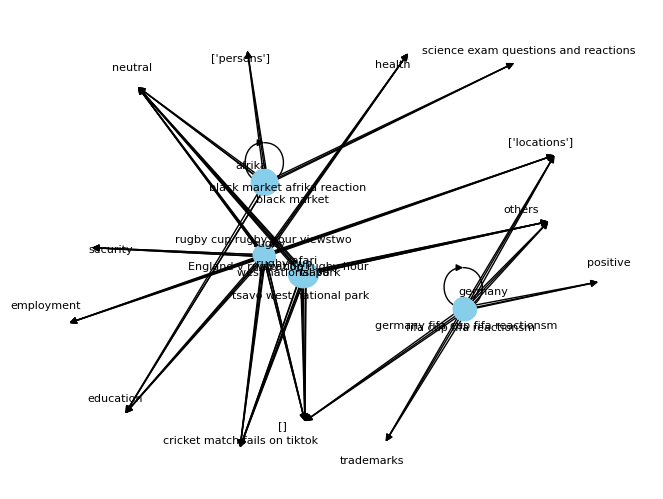

In [129]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df2[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate density for each node
density = {node: nx.density(nx.ego_graph(G, node)) for node in G.nodes()}

# Assign density as weight to each node
for node, dens in density.items():
    G.nodes[node]['weight'] = dens

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on density
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.1):
    """Applies a small random offset to avoid label overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Place labels at adjusted positions
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label positions to avoid overlap
    plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# Do not draw edge labels
# plt.show() will display the graph without edge labels
plt.show()


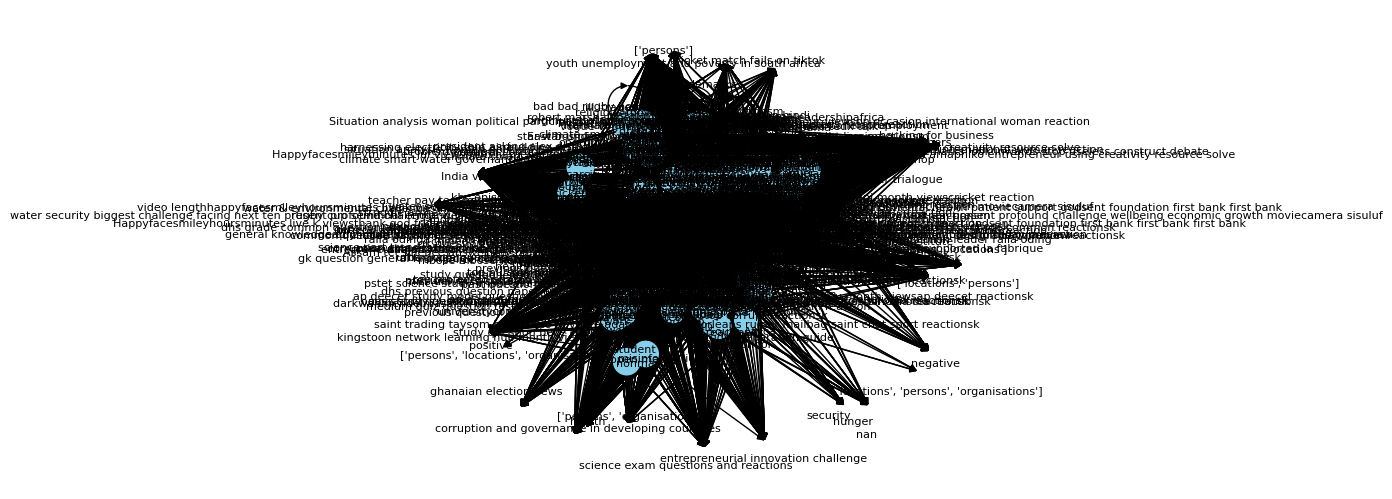

In [130]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import random

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_people[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    time = row['Date']

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)

    for entity in entities:
        G.add_node(entity, type='Entity', time=time)

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate density for each node
density = {node: nx.density(nx.ego_graph(G, node)) for node in G.nodes()}

# Assign density as weight to each node
for node, dens in density.items():
    G.nodes[node]['weight'] = dens

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes with sizes based on density
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw(G, pos, with_labels=False, node_size=[v * 1000 for v in node_weights.values()], node_color='skyblue', font_color='black')

# Function to adjust label positions to avoid overlap
def adjust_label_position(x, y, offset=0.1):
    """Applies a small random offset to avoid label overlap."""
    return x + random.uniform(-offset, offset), y + random.uniform(-offset, offset)

# Place labels at adjusted positions
for node, (x, y) in pos.items():
    new_x, new_y = adjust_label_position(x, y)  # Adjust label positions to avoid overlap
    plt.text(new_x, new_y, node, fontsize=8, ha='center', va='center')

# Do not draw edge labels
# plt.show() will display the graph without edge labels
plt.show()


In [131]:
import networkx as nx

# Assuming 'G' is your graph
# Calculate density for each node
density = {node: nx.density(nx.ego_graph(G, node)) for node in G.nodes()}

# Sort nodes based on density
top_nodes_by_density = sorted(density.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top ten nodes by density:")
for node, dens in top_nodes_by_density:
    print(f"Node: {node}")


Top ten nodes by density:
Node: tedx talk speech
Node: sean stephenson
Node: itrademarkm
Node: central sulawesi
Node: wealth concentration
Node: star war undercover bos starkiller base snl saturday night live reactionsm
Node: tedx talk speech said ne
Node: tiktok keller williams
Node: professor muhammad yunus
Node: zero net carbon emission


Top 20 nodes by PageRank:
Node: neutral, PageRank: 0.07002629541365092
Node: others, PageRank: 0.04238508410106172
Node: science exam questions and reactions, PageRank: 0.03635839076500318
Node: poverty, PageRank: 0.02765346760457887
Node: health, PageRank: 0.019611159734659978
Node: employment, PageRank: 0.018512689098125534
Node: education, PageRank: 0.016577919381690974
Node: hacking for business, PageRank: 0.015602641143615148
Node: positive, PageRank: 0.011568086812982267
Node: entrepreneurial innovation challenge, PageRank: 0.008185697066798236
Node: ghanaian election news, PageRank: 0.006426014136857824
Node: corruption and governance in developing countries, PageRank: 0.005165695331108784
Node: cricket match fails on tiktok, PageRank: 0.004241990519547461
Node: trademarks, PageRank: 0.004179061662203805
Node: water & environmental challenge: innovating for climate resilience, PageRank: 0.0036339331678294394
Node: reactionsk, PageRank: 0.0031813457401296337
Node: youth unemploym

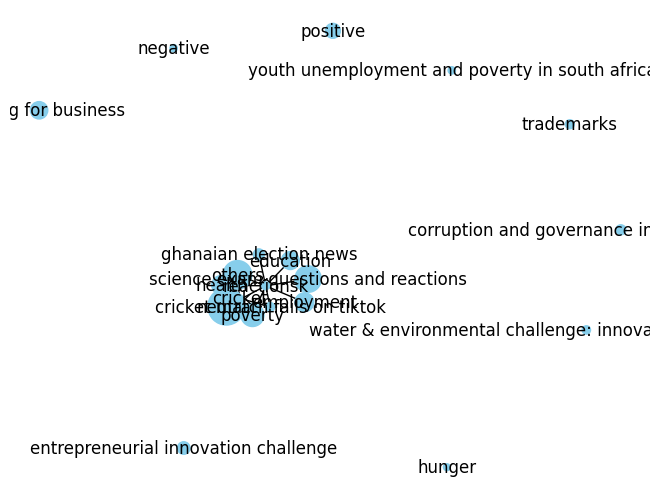

In [132]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df_org'
# Extract relevant columns including 'Head', 'Tail', 'Relations', 'category', 'Views', 'topic', 'sentiment', and 'theme'
df_subset = df_people[['Head', 'Tail', 'Relations', 'category', 'Views', 'topic', 'sentiment', 'theme']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    topic = row['topic']
    sentiment = row['sentiment']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    
    # Add nodes for entities, topic, sentiment, and theme
    for entity in entities:
        G.add_node(entity, type='Entity')
    
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(theme, type='Theme')

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type)

    # Add edges connecting entities to topic, sentiment, and theme
    for entity in entities:
        G.add_edge(entity, topic, type='Topic')
        G.add_edge(entity, sentiment, type='Sentiment')
        G.add_edge(entity, theme, type='Theme')

# Convert the directed graph to an undirected graph for PageRank calculation
G_undirected = G.to_undirected()

# Calculate PageRank for each node
pagerank = nx.pagerank(G_undirected)

# Assign PageRank as an attribute to each node
for node in G_undirected.nodes():
    G_undirected.nodes[node]['pagerank'] = pagerank[node]

# Sort the nodes based on PageRank for analysis
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Display the top 20 nodes with the highest PageRank
print("Top 20 nodes by PageRank:")
for node, rank in sorted_pagerank[:20]:
    print(f"Node: {node}, PageRank: {rank}")

# Visualize the top 20 nodes with the highest PageRank as a subgraph
top_20_nodes = [node for node, _ in sorted_pagerank[:20]]
subgraph = G_undirected.subgraph(top_20_nodes)

# Compute layout for plotting
pos = nx.spring_layout(subgraph)

# Get node sizes based on PageRank (scaled for visualization)
node_sizes = [pagerank[node] * 10000 for node in subgraph.nodes()]

# Draw the graph with PageRank-based node sizes
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=node_sizes)

# Show the plot
plt.show()

# Save the entire graph with PageRank to a GEXF file (for use in Gephi)
nx.write_gexf(G_undirected, "graph_with_pagerank_org.gexf")


In [141]:
df_people

topic                 Date      theme  \
335                    hacking for business  2022-06-13 00:00:00    poverty   
335                    hacking for business  2022-06-13 00:00:00  education   
335                    hacking for business  2022-06-13 00:00:00     health   
766                    hacking for business  2022-02-17 00:00:00     others   
767                    hacking for business  2022-02-17 00:00:00     others   
...                                     ...                  ...        ...   
65622                  hacking for business  2022-11-25 00:00:00  education   
65623                  hacking for business  2022-11-25 00:00:00  education   
66809  science exam questions and reactions           2021-08-24  education   
66810  science exam questions and reactions           2021-08-24  education   
66811  science exam questions and reactions           2021-08-24  education   

                               Head                          Tail sentiment  \
335            jonathan oppenheimer            executive chairman   neutral   
335            jonathan oppenheimer            executive chairman   neutral   
335            jonathan oppenheimer            executive chairman   neutral   
766              anton jeftha boity       david jeftha boitythulo  positive   
767         david jeftha boitythulo            anton jeftha boity  positive   
...                             ...                           ...       ...   
65622                viewspresident               cyril ramaphosa   neutral   
65623               Cyril ramaphosa                viewspresident   neutral   
66809  black market afrika reaction                        afrika   neutral   
66810  black market afrika reaction                  black market   neutral   
66811  black market afrika reaction  black market afrika reaction   neutral   

                                               Relations  \
335    [{'head': 'executive chairman', 'type': 'subcl...   
335    [{'head': 'executive chairman', 'type': 'subcl...   
335    [{'head': 'executive chairman', 'type': 'subcl...   
766    [{'head': 'anton jeftha boity', 'type': 'spous...   
767    [{'head': 'anton jeftha boity', 'type': 'spous...   
...                                                  ...   
65622  [{'head': 'cyril ramaphosa', 'type': 'position...   
65623  [{'head': 'cyril ramaphosa', 'type': 'position...   
66809  [{'head': 'black market afrika reaction', 'typ...   
66810  [{'head': 'black market afrika reaction', 'typ...   
66811  [{'head': 'black market afrika reaction', 'typ...   

                           category Views  
335                     ['persons']    29  
335                     ['persons']    29  
335                     ['persons']    29  
766    ['persons', 'organisations']   625  
767    ['persons', 'organisations']   625  
...                             ...   ...  
65622                   ['persons']   107  
65623                   ['persons']   107  
66809                   ['persons']   858  
66810                   ['persons']   858  
66811                   ['persons']   858  

[1265 rows x 9 columns]

Top 20 nodes by Density:
Node: sslc science, Density: 2.0
Node: solution provider, Density: 2.0
Node: hotcubator, Density: 2.0
Node: 2010, Density: 2.0
Node: business forum, Density: 2.0
Node: forum, Density: 2.0
Node: community, Density: 2.0
Node: schiller institute, Density: 2.0
Node: schiller, Density: 2.0
Node: civil society academy, Density: 2.0
Node: videonot, Density: 2.0
Node: javed akhtar, Density: 2.0
Node: dk, Density: 2.0
Node: inventor, Density: 2.0
Node: Mr. Change Challenge big thank everyone participated last challenge, Density: 2.0
Node: Mr.Change Challenge big thank everyone participated last challenge, Density: 2.0
Node: misinformation, Density: 2.0
Node: csspmslaw, Density: 2.0
Node: 2010 Six Nations Championship, Density: 2.0
Node: mineiroconfusion, Density: 2.0


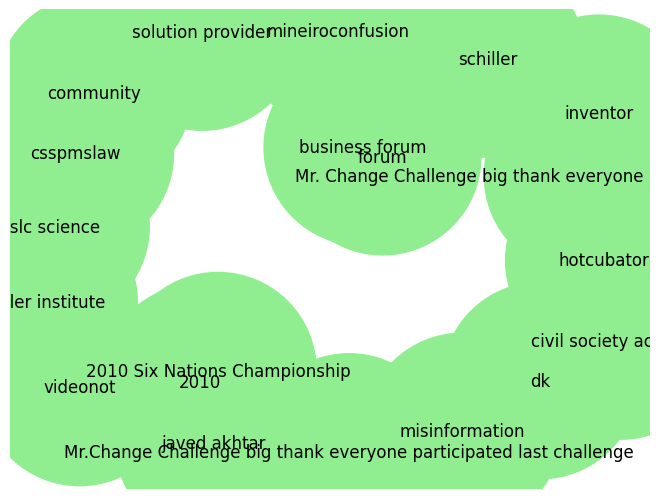

In [142]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df_people'
# Extract relevant columns including 'Head', 'Tail', 'Relations', 'category', 'Views', 'topic', 'sentiment', and 'theme'
df_subset = df_people[['Head', 'Tail', 'Relations', 'category', 'Views', 'topic', 'sentiment', 'theme']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    relations = ast.literal_eval(row['Relations'])
    category = row['category']
    topic = row['topic']
    sentiment = row['sentiment']
    theme = row['theme']
    entities = [row['Head'], row['Tail']]
    
    # Add nodes for entities, topic, sentiment, and theme
    for entity in entities:
        G.add_node(entity, type='Entity')
    
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(theme, type='Theme')

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type)

    # Add edges connecting entities to topic, sentiment, and theme
    for entity in entities:
        G.add_edge(entity, topic, type='Topic')
        G.add_edge(entity, sentiment, type='Sentiment')
        G.add_edge(entity, theme, type='Theme')

# Convert the directed graph to an undirected graph for density calculation
G_undirected = G.to_undirected()

# Calculate density for each node's ego graph
node_density = {node: nx.density(nx.ego_graph(G_undirected, node)) for node in G_undirected.nodes()}

# Assign density as an attribute to each node
for node in G_undirected.nodes():
    G_undirected.nodes[node]['density'] = node_density[node]

# Sort the nodes based on density for analysis
sorted_density = sorted(node_density.items(), key=lambda x: x[1], reverse=True)

# Display the top 20 nodes with the highest density
print("Top 20 nodes by Density:")
for node, dens in sorted_density[:20]:
    print(f"Node: {node}, Density: {dens}")

# Visualize the top 20 nodes with the highest density as a subgraph
top_20_nodes = [node for node, _ in sorted_density[:20]]
subgraph = G_undirected.subgraph(top_20_nodes)

# Compute layout for plotting
pos = nx.spring_layout(subgraph)

# Get node sizes based on density (scaled for visualization)
node_sizes = [node_density[node] * 10000 for node in subgraph.nodes()]

# Draw the graph with density-based node sizes
nx.draw(subgraph, pos, with_labels=True, node_color='lightgreen', node_size=node_sizes)

# Show the plot
plt.show()

# Save the entire graph with density to a GEXF file (for use in Gephi)
nx.write_gexf(G_undirected, "graph_with_density_1k.gexf")


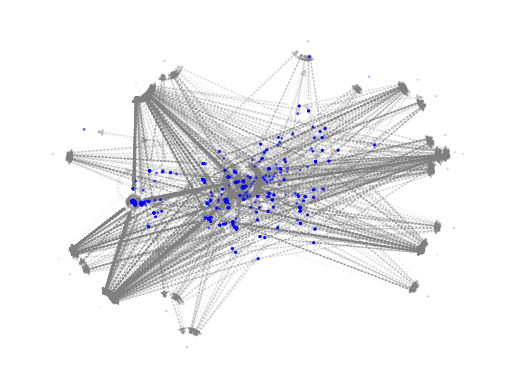

In [134]:
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for data manipulation

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df_education[['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store 'Views' values for each node
views_dict = {}

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    # cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction
    time = row['Date']  # Assuming there is a 'time' column in your DataFrame

    # Add nodes with time information
    G.add_node(topic, type='Topic', time=time)
    G.add_node(sentiment, type='Sentiment', time=time)
    G.add_node(theme, type='Theme', time=time)
    G.add_node(category, type='Category', time=time)
    # G.add_node(cluster, type='Cluster', time=time)
    
    for entity in entities:
        G.add_node(entity, type='Entity', time=time)
        # Store 'Views' value for Head and Tail nodes
        views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
        if entity in views_dict:
            views_dict[entity].append(views)
        else:
            views_dict[entity] = [views]

    # Add edges from Relations with time and views information
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type, time=time)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment', time=time)
        G.add_edge(head, theme, type='Theme', time=time)
        G.add_edge(head, category, type='Category', time=time)
        # G.add_edge(head, cluster, type='Cluster', time=time)
        G.add_edge(head, topic, type='Topic', time=time)

        G.add_edge(tail, sentiment, type='Sentiment', time=time)
        G.add_edge(tail, theme, type='Theme', time=time)
        G.add_edge(tail, category, type='Category', time=time)
        # G.add_edge(tail, cluster, type='Cluster', time=time)
        G.add_edge(tail, topic, type='Topic', time=time)

# Calculate density for each node
node_density = nx.clustering(G)

# Determine node size based on density
node_sizes = [5 * density for node, density in node_density.items()]

# Save the graph in GEXF file format
nx.write_gexf(G, 'graphgcn2.gexf')

# Compute layout for plotting
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G=G, pos=pos, node_color='blue', alpha=0.5, node_size=node_sizes)

# Draw edges
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=True)

plt.axis('off')

# Watermark
plt.text(0.99, 0.01, ' ',
         verticalalignment='bottom',
         horizontalalignment='right',
         transform=plt.gca().transAxes,
         color='grey',
         fontsize=15,
         alpha=0.9)

# Show the plot
plt.show()


In [135]:
# import ast
# import networkx as nx
# import matplotlib.pyplot as plt

# # Assuming your data is stored in a DataFrame named 'df2'
# # Extract relevant columns
# df_subset = df_education[['topic', 'Date', 'theme', 'cluster', 'Head', 'Tail', 'sentiment', 'Relations', 'category', 'Views']]

# # Create a directed graph
# G = nx.DiGraph()

# # Create a dictionary to store 'Views' values for each node
# views_dict = {}

# # Add nodes and edges to the graph
# for _, row in df_subset.iterrows():
#     topic = row['topic']
#     sentiment = row['sentiment']
#     relations = ast.literal_eval(row['Relations'])
#     category = row['category']  # Assuming category is a list
#     theme = row['theme']
#     cluster = row['cluster']
#     entities = [row['Head'], row['Tail']]  # Corrected entities extraction
#     time = row['Date']  # Assuming there is a 'time' column in your DataFrame

#     # Add nodes with time and views information
#     G.add_node(topic, type='Topic', time=time)
#     G.add_node(sentiment, type='Sentiment', time=time)
#     G.add_node(theme, type='Theme', time=time)
#     G.add_node(category, type='Category', time=time)
#     G.add_node(cluster, type='Cluster', time=time)
    
#     for entity in entities:
#         G.add_node(entity, type='Entity', time=time)
#         # Store 'Views' value for Head and Tail nodes
#         views = pd.to_numeric(row['Views'], errors='coerce')  # Convert to numeric, handle errors
#         if entity in views_dict:
#             views_dict[entity].append(views)
#         else:
#             views_dict[entity] = [views]

#     # Add edges from Relations with time and views information
#     for relation in relations:
#         head = relation['head']
#         relation_type = relation['type']
#         tail = relation['tail']
#         G.add_edge(head, tail, type=relation_type, time=time)

#         # Add additional edges for relationships between head/tail and other components
#         G.add_edge(head, sentiment, type='Sentiment', time=time)
#         G.add_edge(head, theme, type='Theme', time=time)
#         G.add_edge(head, category, type='Category', time=time)
#         G.add_edge(head, cluster, type='Cluster', time=time)
#         G.add_edge(head, topic, type='Topic', time=time)

#         G.add_edge(tail, sentiment, type='Sentiment', time=time)
#         G.add_edge(tail, theme, type='Theme', time=time)
#         G.add_edge(tail, category, type='Category', time=time)
#         G.add_edge(tail, cluster, type='Cluster', time=time)
#         G.add_edge(tail, topic, type='Topic', time=time)

# # Save the graph in GEXF file format
# nx.write_gexf(G, 'graphgcn2.gexf')

# # Compute layout for plotting
# pos = nx.spring_layout(G)

# # Convert node sizes to Python float
# node_sizes = [float(np.log1p(sum(views_dict[node]) / len(views_dict[node]))) if node in views_dict and views_dict[node] else 1 for node in G.nodes]

# # Figure
# fig, ax = plt.subplots(figsize=(20, 11))

# # Map "pos" attribute to nodes from pos dict
# for node, position in pos.items():
#     G.nodes[node]['pos'] = position

# # Draw nodes
# nx.draw_networkx_nodes(G=G, pos=nx.get_node_attributes(G, 'pos'), node_color='blue', alpha=0.5,
#                        node_size=node_sizes)

# # Draw edges
# nx.draw_networkx_edges(G=G, pos=nx.get_node_attributes(G, 'pos'), edge_color='grey', style="dotted", alpha=0.1,
#                        arrows=False)

# ax.axis('off')

# # Watermark
# ax.text(0.99, 0.01, '© Github/Sibitenda',
#         verticalalignment='bottom',
#         horizontalalignment='right',
#         transform=ax.transAxes,
#         color='grey',
#         fontsize=15,
#         alpha=0.9)

# # Show the plot
# plt.show()


In [136]:
df2.columns

Index(['topic', 'Date', 'theme', 'Head', 'Tail', 'sentiment', 'Relations',
       'category', 'Views'],
      dtype='object')

In [137]:
df['Date']

95                      2022-08-24
96                      2022-08-24
203                            nan
204                            nan
205                            nan
                   ...            
66786    2019-08-09 09:21:04+00:00
66787    2019-08-09 09:21:04+00:00
66809                   2021-08-24
66810                   2021-08-24
66811                   2021-08-24
Name: Date, Length: 6137, dtype: object

In [138]:
# pip install python-louvain


In [139]:
# # pip install folium

# df_education = df[df['theme'] == 'education']
# df_poverty = df[df['theme'] == 'poverty']
# df_health = df[df['theme'] == 'health']
# df_employment = df[df['theme'] == 'employment']
# df_security = df[df['theme'] == 'security']
# df_hunger = df[df['theme'] == 'hunger']
# print(df_education.shape)



In [140]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df2'
# Extract relevant columns
df_subset = df[['topic', 'theme', 'cluster', 'Head', 'Tail','sentiment', 'Relations', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    relations = ast.literal_eval(row['Relations'])
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    cluster = row['cluster']
    entities = [row['Head'], row['Tail']]  # Corrected entities extraction

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(theme, type='Theme')
    G.add_node(category, type='Category')
    G.add_node(cluster, type='Cluster')

    for entity in entities:
        G.add_node(entity, type='Entity')

    # Add edges from Relations
    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        G.add_edge(head, tail, type=relation_type)

        # Add additional edges for relationships between head/tail and other components
        G.add_edge(head, sentiment, type='Sentiment')
        G.add_edge(head, theme, type='Theme')
        G.add_edge(head, category, type='Category')
        G.add_edge(head, cluster, type='Cluster')
        G.add_edge(head, topic, type='Topic')

        G.add_edge(tail, sentiment, type='Sentiment')
        G.add_edge(tail, theme, type='Theme')
        G.add_edge(tail, category, type='Category')
        G.add_edge(tail, cluster, type='Cluster')
        G.add_edge(tail, topic, type='Topic')

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


KeyError: "['cluster'] not in index"

In [ ]:
"""import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category','Views']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    cluster = row['cluster']
    for column, value in row.items():
        if column not in ['Date', 'Views']:
            G.add_node(value, type=column)
    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')
    G.add_node(category, type='Category')
    G.add_node(cluster, type='Cluster')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
#     G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic')
    G.add_edge(topic, tail, type='Topic')

    G.add_edge(theme, head, type='Theme')
    G.add_edge(theme, tail, type='Theme')
    G.add_edge(sentiment, head, type='sentiment')
    G.add_edge(sentiment, tail, type='sentiment')
    
    G.add_edge(category, head, type='Category')
    G.add_edge(category, tail, type='Category')
    
    G.add_edge(cluster, head, type='Cluster')
    G.add_edge(cluster, tail, type='Cluster')

    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
# Extract 'Views' values to use as node size
node_sizes = {node: row['Views'] for _, row in df.iterrows()}
# Extract 'Views' values to use as node siz
node_sizes = {}
for _, row in df.iterrows():
    for column, value in row.items():
        if column == 'Views':
            node_sizes[value] = row['Views']


# Extract edge weights for thickness
edge_weights_head = [G[node]['Views']['weight'] for node in G['Head']]
edge_weights_tail = [G[node]['Views']['weight'] for node in G['Tail']]

nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')  # Adjusted node_size
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()
"""

In [ ]:
'''""""import ast
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
# df_subset = df[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category','Views']]
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    cluster = row['cluster']
    """    for column, value in row.items():
        if column not in ['Date', 'Views']:
            G.add_node(value, type=column)"""
    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')
    G.add_node(category, type='Category')
    G.add_node(cluster, type='Cluster')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    # G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic')
    G.add_edge(topic, tail, type='Topic')

    G.add_edge(theme, head, type='Theme')
    G.add_edge(theme, tail, type='Theme')
    G.add_edge(sentiment, head, type='sentiment')
    G.add_edge(sentiment, tail, type='sentiment')
    
    G.add_edge(category, head, type='Category')
    G.add_edge(category, tail, type='Category')
    
    G.add_edge(cluster, head, type='Cluster')
    G.add_edge(cluster, tail, type='Cluster')

    # Add edges between Head, Tail, and Views
    G.add_edge(row['Head'], row['Tail'], type=row['Relation_Type'])
    #G.add_edge(row['Head'], 'Views', type=f"Head_Views", weight=row['Views'])
#     G.add_edge(row['Tail'], 'Views', type=f"Tail_Views", weight=row['Views'])

# Draw the graph with adjusted node size based on 'Views' for 'Head' and 'Tail' columns
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')

"""# Extract 'Views' values to use as node size
node_sizes = {node: row['Views'] for _, row in df.iterrows()}

# Extract edge weights for thickness
edge_weights_head = [G[node]['Views']['weight'] for node in G['Head']]
edge_weights_tail = [G[node]['Views']['weight'] for node in G['Tail']]"""

nx.draw(G, pos, with_labels=True, font_size=8, node_size=[node_sizes[node] for node in G.nodes], node_color='skyblue', font_color='black', width=edge_weights_head + edge_weights_tail)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()
""""'''

In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_2allnew.gexf")


In [ ]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [ ]:
df.columns

In [ ]:
from operator import itemgetter

def networkStats(G):
    """
    This function prints the basic properties of the graph and additional network statistics.
    """
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    density = nx.density(G)
    print("Network density:", density)

    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G)  # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G)  # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

# Assuming G is the graph you created in the previous code
networkStats(G)


In [ ]:
from operator import itemgetter

def networkStats(G):
    """
    This function prints various network statistics.
    """
    # Basic properties
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    # Density
    density = nx.density(G)
    print("Network density:", density)

    # Triadic closure
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    # Degree distribution
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    # Betweenness centrality
    betweenness_dict = nx.betweenness_centrality(G)
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

    # Eigenvector centrality
    eigenvector_dict = nx.eigenvector_centrality(G)
    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by eigenvector centrality:\n")
    for e in sorted_eigenvector[:5]:
        print(e)

#     # Clustering coefficient (only for weakly connected graphs)
#     if nx.is_weakly_connected(G):
#         clustering_coefficient = nx.average_clustering(G.to_undirected())
#         print("Average clustering coefficient:", clustering_coefficient)
#     else:
#         print("Graph is not weakly connected. Clustering coefficient not computed.")

#     # Shortest path length (only for strongly connected graphs)
#     if nx.is_strongly_connected(G):
#         avg_shortest_path = nx.average_shortest_path_length(G)
#         print("Average shortest path length:", avg_shortest_path)
#     else:
#         print("Graph is not strongly connected. Shortest path length not computed.")

#     # Global efficiency
#     global_efficiency = nx.global_efficiency(G)
#     print("Global efficiency:", global_efficiency)

#     # Assortativity
#     assortativity = nx.assortativity.degree_assortativity_coefficient(G)
#     print("Assortativity:", assortativity)

# Assuming G is the graph you created in the previous code
networkStats(G)


In [ ]:
# import networkx as nx
# import numpy as np

# # Assuming G is your graph
# # Convert numpy.ndarray and other supported attribute types to lists
# for node, data in G.nodes(data=True):
#     for key, value in data.items():
#         if isinstance(value, (np.ndarray, list)):
#             G.nodes[node][key] = value
#         elif isinstance(value, (int, float, str)):
#             G.nodes[node][key] = [value]

# # Save the graph to a GEXF file (Gephi file format)
# nx.write_gexf(G, "graph_gcn.gexf")
# nx.write_gexf(G, "graph_gcn.gexf")


# Network Centrality Measures
Complex networks by definition are highly heterogeneous structures. This often results in some parts of the network being more information-rich than others. For example, in social networks, some individuals might have a large number of connections and can spread information faster than others. Hence, within the context of social network analysis, the nodes that represent them are considered more important(central). Within the context of transportation networks, an urban region where the influx of people is higher than in the other areas can be considered central. However, the centrality of a given network may change over time as a result of the growth and evolution of the underlying system. Thus, the definition of centrality is not absolute but rather depends on the specific context and the purpose of the abstraction. Taking this relativity into account, several centrality measures have been proposed that focus on different types of relationships between the nodes.

# Degree Centrality

Degree centrality is the most simple centrality measure to understand and compute. "Degree" of a node refers to the number of nodes that a given node is connected to. Within the context of city bikes, this refers to the number of bike stations that users have travelled to from the target station. As we can see in the graph below stations located in central Helsinki have a higher number of connections. Closer to the periphery of the network the degree of the nodes gradually decreases.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def centralityDegree(G):
    # Compute layout positions
    pos = nx.spring_layout(G)

    # Set positions as 'pos' attributes for nodes
    nx.set_node_attributes(G, pos, 'pos')

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Get node positions
    node_positions = nx.get_node_attributes(G, 'pos')

    # Filter nodes with valid positions and 'pos' attribute
    valid_nodes = [node for node in G.nodes if node in node_positions and 'pos' in G.nodes[node]]

    # Filter edges involving nodes with valid positions
    valid_edges = [(u, v) for u, v in G.edges if u in valid_nodes and v in valid_nodes]

    # Create color scale
    colors = range(20)
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G=G, pos=node_positions, nodelist=valid_nodes, node_color=node_color, cmap="viridis", alpha=1, node_size=50)

    # Draw edges
    edges = nx.draw_networkx_edges(G=G, pos=node_positions, edgelist=valid_edges, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Create colorbar
    cbar = plt.colorbar(sm, ax=ax)

    # Labeling Axes
    ax.set_title('Social concerns Network Degree Centrality', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()

# function call is commented for performance reasons
centralityDegree(G)


In [ ]:
# print("Nodes:", G.nodes())
# print("Edges:", G.edges())
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")


# Betweenness Centrality

The betweenness centrality captures how much a given node is "in-between" others. This measure calculates the shortest paths between all the nodes of the network and assigns each node a measure based on the number of shortest paths going through the target node. The graph below illustrates the city bike stations by betweenness centrality.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def centralityDegree(G, centrality_measure):
    # Compute layout positions
    pos = nx.spring_layout(G)

    # Set positions as 'pos' attributes for nodes
    nx.set_node_attributes(G, pos, 'pos')

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    # Compute centrality measure
    centrality = centrality_measure(G)

    # Get node positions
    node_positions = nx.get_node_attributes(G, 'pos')

    # Filter nodes with valid positions and 'pos' attribute
    valid_nodes = [node for node in G.nodes if node in node_positions and 'pos' in G.nodes[node]]

    # Filter edges involving nodes with valid positions
    valid_edges = [(u, v) for u, v in G.edges if u in valid_nodes and v in valid_nodes]

    # Create color scale
    colors = range(20)
    cmap = plt.cm.viridis
    vmin = min(centrality.values())
    vmax = max(centrality.values())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G=G, pos=node_positions, nodelist=valid_nodes, node_color=list(centrality.values()), cmap="viridis", alpha=1, node_size=50)

    # Draw edges
    edges = nx.draw_networkx_edges(G=G, pos=node_positions, edgelist=valid_edges, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Create colorbar
    cbar = plt.colorbar(sm, ax=ax)

    # Labeling Axes
    ax.set_title(f'Social concerns Network {centrality_measure.__name__}', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()

# # Create a graph (replace this with your actual graph creation or loading)
# G = nx.Graph()

# # Add nodes and edges to the graph (replace this with your actual data)
# G.add_nodes_from(['-1_people_country_also_trade', 'negative', 'subcontinent', 'china', 'poverty', "['locations']"])
# G.add_edges_from([('-1_people_country_also_trade', 'negative'), ('negative', 'subcontinent'), ('subcontinent', 'china'), ('china', 'poverty'), ('poverty', "['locations']")])

# Call the centralityDegree function with Betweenness Centrality
centralityDegree(G, nx.betweenness_centrality)


# Closeness Centrality
Closeness centrality is a way of detecting nodes that are able to distribute flows efficiently through the network. The closeness centrality is calculated as the normalized average of all of its geodesic distances. Within the context of the city bikes, a node with high closeness centrality will indicate stations that can potentially act as versatile intermediary stations within the network.

In [ ]:
def centralityCloseness(G):
    """
    This function plots an interactive social concerns network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors = range(20)
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size=50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Social concerns Network Closeness Centrality', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    # Create a separate Axes for the colorbar
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
    plt.colorbar(sm, cax=cax)

    plt.show()

centralityCloseness(G)


# Eigenvector centrality & PageRank
Eigenvector centrality measures a node's importance within the network while giving consideration to the importance of its neighbours. Connections to high-scoring eigenvector centrality nodes contribute more to the score than equal connections to low-scoring nodes. In other words, a node with a large number of connections may have a low Eigenvector score if all of its connections are with low-score nodes. A popular variation of eigenvector centrality is Google's PageRank. In essence, PageRank is a variation of normalized eigenvector centrality combined with random jumps. Thus it is not surprising that Pagerank yields result comparable to Eigenvector(graphs below). With this method, stations like the Central Railway Station, Pasila, Lehtisaarentie and Haukilahdenkatu appear as central nodes within the network.

In [ ]:
def centralityEigenvector(G):
    """
    This function plots the social concerns network Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Social concerns Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    # Create a separate Axes for the colorbar
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
    plt.colorbar(sm, cax=cax)

    plt.show()

# function call is commented for performance reasons
centralityEigenvector(G)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def centralityDegree(G, centrality_measure):
    # Compute layout positions
    pos = nx.spring_layout(G)

    # Set positions as 'pos' attributes for nodes
    nx.set_node_attributes(G, pos, 'pos')

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    # Compute centrality measure
    centrality = centrality_measure(G)

    # Get node positions
    node_positions = nx.get_node_attributes(G, 'pos')

    # Filter nodes with valid positions and 'pos' attribute
    valid_nodes = [node for node in G.nodes if node in node_positions and 'pos' in G.nodes[node]]

    # Filter edges involving nodes with valid positions
    valid_edges = [(u, v) for u, v in G.edges if u in valid_nodes and v in valid_nodes]

    # Create color scale
    colors = range(20)
    cmap = plt.cm.viridis
    vmin = min(centrality.values())
    vmax = max(centrality.values())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G=G, pos=node_positions, nodelist=valid_nodes, node_color=list(centrality.values()), cmap="viridis", alpha=1, node_size=50)

    # Draw edges
    edges = nx.draw_networkx_edges(G=G, pos=node_positions, edgelist=valid_edges, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Create colorbar
    cbar = plt.colorbar(sm, ax=ax)

    # Labeling Axes
    ax.set_title(f'Social concerns Network {centrality_measure.__name__}', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()


# Call the centralityDegree function with PageRank
centralityDegree(G, nx.pagerank)


# Community Detection
Communities in networks refer to groups of nodes that are densely connected internally. Community detection is often a crucial process for understanding the structure of complex networks. 

# Louvain Method
Since the previous community detection method did not yield insightful results we can apply a different method that only focuses on the modularity of the network. The Louvain community detection algorithm is chosen due to its beautiful simplicity and the resulting ease of implementation/computation. It allows circumventing the NP-complete problem of maximum cuts in Graphs. Applying the Louvain method to the Helsinki city bike network reveals four distinct communities.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain

def communityLouvain(G):
    """
    This function applies the Louvain method for community detection on the social concerns network.
    """

    # Convert directed graph to undirected graph
    G_undirected = G.to_undirected()

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    # Compute Louvain method
    partition = community_louvain.best_partition(G_undirected, resolution=0.95, random_state=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    node_positions = nx.spring_layout(G_undirected)  # You can use a different layout if needed
    nx.draw_networkx_nodes(G_undirected, node_positions, nodelist=partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_undirected, node_positions, alpha=0.015)

    # Labeling Axes
    ax.set_title('Social concerns Network Communities (Louvain method)', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()

# Call the function with the directed graph G
communityLouvain(G)


In [ ]:
# import networkx as nx
# print("Number of nodes:", G_undirected.number_of_nodes())
# print("Number of edges:", G_undirected.number_of_edges())
# node_positions = nx.get_node_attributes(G_undirected, 'pos')
# print("Node positions:", node_positions)


# Fluid Communities Method
The Fluid Communities algorithm is a community detection algorithm based on the idea of introducing a number of fluids within a non-homogeneous environment, where fluids will expand and push each other influenced by the topology of the environment until a stable state is reached. The algorithm does the following. First, it defines each of the starting communities in a random node of the graph. Then the algorithm iterates over all nodes in a random order, updating the community of each node based on its own community and the communities of its neighbours. This process is performed iteratively until convergence.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def communityFluid(G):
    """
    This function applies the Fluid Communities method for community detection on the social concerns network.
    """

    # Convert directed graph to undirected
    G_undirected = nx.Graph(G)

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Fluid method
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(G_undirected, k=5, max_iter=10000, seed=1)

    # Assigning each node to its cluster
    partition = {}
    for idx, val in enumerate(communities):
        for k in val:
            partition[k] = idx

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G_undirected, G_undirected.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_undirected, G_undirected.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Social concerns Network Communities (Fluid Communities method)', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Sibitenda',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    plt.show()

# Call the function with your graph
communityFluid(G)


This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

In [ ]:
df2

In [ ]:

df_education = df[df['theme'] == 'education']
df_poverty = df[df['theme'] == 'poverty']
df_health = df[df['theme'] == 'health']
df_employment = df[df['theme'] == 'employment']
df_security = df[df['theme'] == 'security']
df_hunger = df[df['theme'] == 'hunger']
print(df_education.shape)


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_21.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_education[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']
    cluster = row['cluster']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')
    G.add_node(category, type='Category')
    G.add_node(cluster, type='Cluster')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
#     G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic')
    G.add_edge(topic, tail, type='Topic')
#     G.add_edge(theme, sentiment, type='Theme_Sentiment')
#     G.add_edge(category, sentiment, type='Category_Sentiment')

#     G.add_edge(topic, theme, type='Topics_Theme')
#     G.add_edge(topic, category, type='Topic_Category')

#     G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme')
    G.add_edge(theme, tail, type='Theme')
    G.add_edge(sentiment, head, type='sentiment')
    G.add_edge(sentiment, tail, type='sentiment')
    
    G.add_edge(category, head, type='Category')
    G.add_edge(category, tail, type='Category')
    
    G.add_edge(cluster, head, type='Cluster')
    G.add_edge(cluster, tail, type='Cluster')

    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')  # Adjusted node_size
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_2educ.gexf")


In [ ]:
df['theme'].unique()

In [ ]:
df_education.columns

In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_education[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_education.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_poverty[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_poverty.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_hunger[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_hunger.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_security[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_security.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_employment[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_employment.gexf")


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df_health[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    category = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Head, Tail, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic_Tail')
    G.add_edge(theme, sentiment, type='Theme_Sentiment')
    G.add_edge(category, sentiment, type='Category_Sentiment')

    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_Category')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    G.add_edge(sentiment, head, type='sentiment_Head')
    G.add_edge(sentiment, tail, type='sentiment_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph_health.gexf")


In [ ]:
import ast

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
#     cluster = row['cluster']
    categories = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
#     G.add_node(cluster, type='Cluster')
    
#     # Add nodes for each value in the 'category' list
#     for category in categories:
#         G.add_node(category, type='Category')
    
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Cluster, Category, and Theme
    G.add_edge(topic, sentiment, type='Topic_Sentiment')
    G.add_edge(head, sentiment, type='Entity_Sentiment')
    G.add_edge(tail, sentiment, type='Entity_Sentiment')
    G.add_edge(theme, sentiment, type='Theme_sentiment')
    G.add_edge(category, sentiment, type='Category_sentiment')
# #     G.add_edge(topic, cluster, type='Topic-Cluster')
#     for category in categories:
#         G.add_edge(topic, category, type='Topic-Category')
    G.add_edge(topic, theme, type='Topics_Theme')
    G.add_edge(topic, category, type='Topic_category')
    G.add_edge(topic, head, type='Topic_Head')
    G.add_edge(topic, tail, type='Topic-Tail')

    G.add_edge(theme, category, type='Theme_Category')
    G.add_edge(theme, head, type='Theme_Head')
    G.add_edge(theme, tail, type='Theme_Tail')
    
    G.add_edge(category, head, type='Category_Head')
    G.add_edge(category, tail, type='Category_Tail')
    
    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=row['Relation_type'])

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph4.gexf")


In [ ]:
import ast

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df[['topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    cluster = row['cluster']
    categories = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(cluster, type='Cluster')
    
    # Add nodes for each value in the 'category' list
    for category in categories:
        G.add_node(category, type='Category')
    
    G.add_node(theme, type='Theme')

    # Add edges between Topic, Sentiment, Cluster, Category, and Theme
    G.add_edge(topic, sentiment, type='Topic-Sentiment')
    G.add_edge(topic, cluster, type='Topic-Cluster')
    for category in categories:
        G.add_edge(topic, category, type='Topic-Category')
    G.add_edge(topic, theme, type='Topic-Theme')

    # Add edges between Topic and Head
    G.add_edge(topic, head, type='Topic-Head')

    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph3.gexf")


In [ ]:
import ast

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df[['Text_lemma', 'topic', 'theme', 'cluster', 'sentiment', 'Head', 'Relation_Type', 'Tail', 'category']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df_subset.iterrows():
    text = row['Text_lemma']
    topic = row['topic']
    sentiment = row['sentiment']
    head = row['Head']
    relation_type = row['Relation_Type']
    tail = row['Tail']
    cluster = row['cluster']
    categories = row['category']  # Assuming category is a list
    theme = row['theme']

    # Add nodes
#     G.add_node(text, type='Text')
    G.add_node(topic, type='Topic')
    G.add_node(sentiment, type='Sentiment')
    G.add_node(head, type='Head')
    G.add_node(tail, type='Tail')
    G.add_node(cluster, type='Cluster')
    
    # Add nodes for each value in the 'category' list
    for category in categories:
        G.add_node(category, type='Category')
    
    G.add_node(theme, type='Theme')

    # Add edges between Text, Topic, Sentiment, Cluster, Category, and Theme
    G.add_edge(text, topic, type='Text-Topic')
    G.add_edge(text, sentiment, type='Topic-Sentiment')
    G.add_edge(text, cluster, type='Topic-Cluster')
    for category in categories:
        G.add_edge(text, category, type='Topic-Category')
    G.add_edge(text, theme, type='Topic-Theme')

    # Add edges between Text and Head
    G.add_edge(text, head, type='Text-Head')

    # Add edges between Head and Tail using the 'Relation_Type' column
    G.add_edge(head, tail, type=relation_type)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'type')
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [ ]:
# df['category']
# Save the graph to a GEXF file (Gephi file format)
nx.write_gexf(G, "graph2.gexf")


In [ ]:
df.shape

In [ ]:
import pandas as pd
from pyecharts import options as opts
from pyecharts.charts import Graph

# Assuming your data is stored in a DataFrame named 'df'
# Extract relevant columns
df_subset = df[['topic', 'theme', 'cluster', 'sentiment', 'Entity_Pairs', 'Relations', 'category']]

# Create a directed graph
nodes = []
links = []

for _, row in df_subset.iterrows():
    topic = row['topic']
    sentiment = row['sentiment']
    entities = row['Entity_Pairs']
    relations = ast.literal_eval(row['Relations'])  # Convert the string to a dictionary
    cluster = row['cluster']
    categories = row['category']  # Assuming category is a list
    theme = row['theme']

    nodes.extend([
        {"name": topic, "symbolSize": 10, "category": "Topic"},
        {"name": sentiment, "symbolSize": 10, "category": "Sentiment"},
        {"name": cluster, "symbolSize": 10, "category": "Cluster"},
        {"name": theme, "symbolSize": 10, "category": "Theme"},
    ])

    for category in categories:
        nodes.append({"name": category, "symbolSize": 10, "category": "Category"})

    links.extend([
        {"source": topic, "target": sentiment},
        {"source": topic, "target": cluster},
        {"source": topic, "target": theme},
    ])

    for entity in entities:
        nodes.append({"name": entity, "symbolSize": 5, "category": "Entity"})
        links.append({"source": topic, "target": entity})

    for relation in relations:
        head = relation['head']
        relation_type = relation['type']
        tail = relation['tail']
        nodes.append({"name": head, "symbolSize": 5, "category": "Relation"})
        nodes.append({"name": tail, "symbolSize": 5, "category": "Relation"})
        links.append({"source": head, "target": tail, "value": relation_type})

# Create the graph
graph = (
    Graph(init_opts=opts.InitOpts(width="1000px", height="600px"))
    .add(
        "",
        nodes=nodes,
        links=links,
        layout="force",
        edge_symbol=["circle", "arrow"],
        edge_symbol_size=[4, 10],
        label_opts=opts.LabelOpts(is_show=False),
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        emphasis_label_opts=opts.LabelOpts(
            is_show=True, color="#fff", position="inside", font_size=10
        ),

#         emphasis_edge_opts=opts.EdgeStyleOpts(
#             color="#FFA500", curve=0.3, width=2, opacity=0.7
#         ),
        emphasis_edge_opts=opts.LineStyleOpts(
            color="#FFA500", curve=0.3, width=2, opacity=0.7
        ),

    )
    .set_global_opts(
        legend_opts=opts.LegendOpts(is_show=False),
        title_opts=opts.TitleOpts(title="Interactive Graph"),
    )
)

# Save the graph as an HTML file
graph.render("interactive_graph.html")


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import pandas as pd

# Assuming 'Type' is the column containing relation labels
num_labels = len(df['Relation_Type'].unique())

# Load BERT tokenizer and model for sequence classification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to('cuda')  # Adjust num_labels and move the model to CUDA

# Assuming 'Type' is the column containing relation labels
df['relation_type'] = df['Relation_Type'].apply(lambda x: str(x))
num_labels = len(df['relation_type'].unique())

# Add label ids to the DataFrame
df['label_id'] = df['relation_type'].astype('category').cat.codes

# Convert 'head' and 'tail' columns to lists
df['Head'] = df['Head'].apply(lambda x: [x])
df['Tail'] = df['Tail'].apply(lambda x: [x])

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, df, max_length=64):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        inputs = tokenizer(
            self.df.iloc[idx]["Text_lemma"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        label = torch.tensor(self.df.iloc[idx]["label_id"]).long().to('cuda')  # Convert to long for CrossEntropyLoss and move to CUDA
        return {"input_ids": inputs["input_ids"].squeeze(), "attention_mask": inputs["attention_mask"].squeeze(), "label": label}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_relation_classification",
    per_device_train_batch_size=8,
    save_total_limit=1,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
)

# Training in chunks
chunk_size = 1000
for start in range(0, len(train_df), chunk_size):
    end = start + chunk_size
    chunk_train_df = train_df.iloc[start:end]

    # Create dataset for the current chunk
    chunk_train_dataset = CustomDataset(chunk_train_df)

    # Update trainer's train_dataset
    trainer.train_dataset = chunk_train_dataset

    # Create evaluation dataset for the current chunk
    chunk_eval_dataset = CustomDataset(test_df)  # You might need to modify this based on your requirements

    # Update trainer's eval_dataset
    trainer.eval_dataset = chunk_eval_dataset

    # Train the model on the current chunk
    trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate(chunk_eval_dataset)

# Print evaluation results
print("***** Evaluation Results *****")
for key, value in results.items():
    print(f"{key}: {value}")

# Get predictions on the test set
predictions = trainer.predict(chunk_eval_dataset)

# Convert logits (numpy array) to PyTorch tensor
predicted_labels = torch.argmax(torch.from_numpy(predictions.predictions), dim=1)

# Convert tensor to list
predicted_labels = predicted_labels.tolist()
true_labels = test_df['label_id'].tolist()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate precision, recall, f1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import pandas as pd

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Assuming 'category' is the column containing labels
# Convert the 'category' column to a string representation
df['category'] = df['Entity_Categories'].apply(lambda x: str(x))
num_labels = len(df['category'].unique())

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Add label ids to the DataFrame
df['label_id'] = df['category'].astype('category').cat.codes

# Convert 'head' and 'tail' columns to lists
df['Head'] = df['Head'].apply(lambda x: [x])
df['Tail'] = df['Tail'].apply(lambda x: [x])

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, df, max_length=64):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        inputs = tokenizer(
            self.df.iloc[idx]["Text_lemma"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        label = torch.tensor(self.df.iloc[idx]["label_id"]).long()  # Convert to long for BCEWithLogitsLoss
        return {"input_ids": inputs["input_ids"].squeeze(), "attention_mask": inputs["attention_mask"].squeeze(), "label": label}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_joint_entity_relation",
    per_device_train_batch_size=8,
    save_total_limit=1,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
)

# Training in chunks
chunk_size = 1000
for start in range(0, len(train_df), chunk_size):
    end = start + chunk_size
    chunk_train_df = train_df.iloc[start:end]

    # Create dataset for the current chunk
    chunk_train_dataset = CustomDataset(chunk_train_df)

    # Update trainer's train_dataset
    trainer.train_dataset = chunk_train_dataset

    # Create evaluation dataset for the current chunk
    chunk_eval_dataset = CustomDataset(test_df)  # You might need to modify this based on your requirements

    # Update trainer's eval_dataset
    trainer.eval_dataset = chunk_eval_dataset

    # Train the model on the current chunk
    trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate(chunk_eval_dataset)

# Print evaluation results
print("***** Evaluation Results *****")
for key, value in results.items():
    print(f"{key}: {value}")

# Get predictions on the test set
predictions = trainer.predict(chunk_eval_dataset)

# Convert logits (numpy array) to PyTorch tensor
predicted_labels = torch.argmax(torch.from_numpy(predictions.predictions), dim=1)

# Convert tensor to list
predicted_labels = predicted_labels.tolist()
true_labels = test_df['label_id'].tolist()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate precision, recall, f1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import pandas as pd

# Assuming 'Type' is the column containing relation labels
num_labels = len(df['Type'].unique())


# Load BERT tokenizer and model for sequence classification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)  # Adjust num_labels
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Assuming 'Type' is the column containing relation labels
df['relation_type'] = df['Type'].apply(lambda x: str(x))
num_labels = len(df['relation_type'].unique())

# Add label ids to the DataFrame
df['label_id'] = df['relation_type'].astype('category').cat.codes

# Convert 'head' and 'tail' columns to lists
df['Head'] = df['Head'].apply(lambda x: [x])
df['Tail'] = df['Tail'].apply(lambda x: [x])

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, df, max_length=64):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        inputs = tokenizer(
            self.df.iloc[idx]["Text_lemma"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        label = torch.tensor(self.df.iloc[idx]["label_id"]).long()  # Convert to long for CrossEntropyLoss
        return {"input_ids": inputs["input_ids"].squeeze(), "attention_mask": inputs["attention_mask"].squeeze(), "label": label}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_relation_classification",
    per_device_train_batch_size=8,
    save_total_limit=1,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
)

# Training in chunks
chunk_size = 1000
for start in range(0, len(train_df), chunk_size):
    end = start + chunk_size
    chunk_train_df = train_df.iloc[start:end]

    # Create dataset for the current chunk
    chunk_train_dataset = CustomDataset(chunk_train_df)

    # Update trainer's train_dataset
    trainer.train_dataset = chunk_train_dataset

    # Create evaluation dataset for the current chunk
    chunk_eval_dataset = CustomDataset(test_df)  # You might need to modify this based on your requirements

    # Update trainer's eval_dataset
    trainer.eval_dataset = chunk_eval_dataset

    # Train the model on the current chunk
    trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate(chunk_eval_dataset)

# Print evaluation results
print("***** Evaluation Results *****")
for key, value in results.items():
    print(f"{key}: {value}")

# Get predictions on the test set
predictions = trainer.predict(chunk_eval_dataset)

# Convert logits (numpy array) to PyTorch tensor
predicted_labels = torch.argmax(torch.from_numpy(predictions.predictions), dim=1)

# Convert tensor to list
predicted_labels = predicted_labels.tolist()
true_labels = test_df['label_id'].tolist()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate precision, recall, f1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch as cuda
import wikipedia
from newspaper import Article, ArticleException
from GoogleNews import GoogleNews
import IPython
from pyvis.network import Network
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Load model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
# model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large").to(device)

def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

class KB():
    def __init__(self):
        self.entities = {}
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def get_wikipedia_data(self, candidate_entity):
        try:
            # Replace this with your own method to get Wikipedia data
            # as this is a placeholder
            entity_data = {
                "title": candidate_entity,
                "url": f"https://en.wikipedia.org/wiki/{candidate_entity}",
                "summary": f"Summary for {candidate_entity}"
            }
            return entity_data
        except:
            return None

    def add_entity(self, e):
        self.entities[e["title"]] = {k: v for k, v in e.items() if k != "title"}

    def add_relation(self, r):
        # check on wikipedia
        candidate_entities = [r["head"], r["tail"]]
        entities = [self.get_wikipedia_data(ent) for ent in candidate_entities]

        # if one entity does not exist, stop
        if any(ent is None for ent in entities):
            return

        # manage new entities
        for e in entities:
            self.add_entity(e)

        # rename relation entities with their wikipedia titles
        r["head"] = entities[0]["title"]
        r["tail"] = entities[1]["title"]

        # manage new relation
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Entities:")
        for e in self.entities.items():
            print(f"  {e}")
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")
            
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
#     inputs = tokenizer([text], return_tensors="pt").to(device)
    inputs = tokenizer([text], return_tensors="pt", max_length=64, truncation=True).to(device)


    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 64,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb
# Split the DataFrame into chunks of 1000 records
chunk_size = 1000
num_chunks = math.ceil(len(df) / chunk_size)

for chunk_number in range(num_chunks):
    start_index = chunk_number * chunk_size
    end_index = (chunk_number + 1) * chunk_size
    current_chunk_df = df.iloc[start_index:end_index]

    result_list = []

    for text in current_chunk_df['Text_lemma']:
        # Process the text and create a KB instance
        kb = from_text_to_kb(text)

        # Extract information from the KB instance
        entities = kb.entities.items()
        relations = kb.relations

        # Append the information to the result list
        result_list.append({'Text_lemma': text, 'Entities': entities, 'Relations': relations})

    # Convert the list of dictionaries into a DataFrame
    result_df = pd.DataFrame(result_list)
    def extract_relation_info(relations):
        if not relations:
            return pd.Series({'Head': None, 'Type': None, 'Tail': None, 'Spans': None})
        relation = relations[0]  # Assuming only one relation per row
        head = relation.get('head')
        tail = relation.get('tail')
        relation_type = relation.get('type')
        spans = relation.get('meta', {}).get('spans')

        return pd.Series({'Head': head, 'Type': relation_type, 'Tail': tail, 'Spans': spans})

    # Apply the custom function to create new columns
    result_df[['Head', 'Type', 'Tail', 'Spans']] = result_df['Relations'].apply(extract_relation_info)

    # Define the function to extract entity categories
    def extract_entity_categories(text):
        # Assume you have the 'nlp' object defined somewhere in your code
        doc = nlp(str(text))  # Convert dict_items to string
        entity_categories = set()

        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                entity_categories.add('persons')
            elif ent.label_ == 'ORG':
                entity_categories.add('organisations')
            elif ent.label_ == 'GPE':
                entity_categories.add('locations')

        return list(entity_categories)

    # Create a new column 'Entity_Categories' in the DataFrame
    result_df['Entity_Categories'] = result_df['Entities'].apply(extract_entity_categories)

    # Save the results to a file (adjust the file format as needed)
    result_filename = f'results_chunk_{chunk_number + 1}.csv'
    result_df.to_csv(result_filename, index=False)

    print(f'Chunk {chunk_number + 1} processed and saved to {result_filename}')
result_df.head()
# Optional: Concatenate the saved results into a single DataFrame if needed
# combined_results_df = pd.concat([pd.read_csv(f) for f in result_filenames], ignore_index=True)

In [ ]:
def save_network_html(kb, filename="network_new.html"):
    # create network
    net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")

    # nodes
    color_entity = "#00FF00"
    for e in kb.entities:
        net.add_node(e, shape="circle", color=color_entity)

    # edges
    for r in kb.relations:
        net.add_edge(r["head"], r["tail"],
                    title=r["type"], label=r["type"])

    # save network
    net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
    net.set_edge_smooth('dynamic')
    net.show(filename)

In [ ]:
result_df['Entities'][4]

In [ ]:
result_df['Relations'][4]

In [ ]:
df

In [ ]:
# kb

In [ ]:
# kb.relations
# kb.entities
df['Relations']=df['Relations'].tolist()
df['Entities']= df['Entities'].tolist()

In [ ]:
from pyvis.network import Network
from IPython.display import display, HTML

def show_network_html(df, filename="network2.html"):
    # create network
    net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")

    # nodes
    color_entity = "#00FF00"
    for entities in df['Entities']:
        for entity in entities:
            entity_title, _ = entity
            net.add_node(entity_title, shape="circle", color=color_entity)

    # edges
    for index, row in df.iterrows():
        head = row['Head']
        tail = row['Tail']
        relation_type = row['Type']
        if not pd.isnull(head) and not pd.isnull(tail) and not pd.isnull(relation_type):
            net.add_edge(head, tail, title=relation_type, label=relation_type)

    # save network as HTML
    net.save_graph(filename)

    # display the network in the notebook
    with open(filename, 'r') as file:
        html_content = file.read()
        display(HTML(html_content))

# call the function
show_network_html(df)


In [ ]:
# final_df.to_csv('D:/senego/dataafrica/analysis/output_luke_final_new2.csv', index=False)
df3=pd.read_csv('D:/senego/dataafrica/analysis/output_luke_final_new2.csv')#, index=False)


In [ ]:
df3.columns

In [ ]:
df2=df3[['Text_lemma', 'entity_pairs', 'predictions','tokens_with_labels', 'predicted_labels']]
df2.head()

In [ ]:
df3['entity_pairs'][45]

In [ ]:
df3['tokens_with_labels'][45]

In [ ]:
df3['text_in_spans'][45]

In [ ]:
df3['predicted_labels'][28]

In [ ]:
df3['entity'][45]

In [ ]:
df3['original_word_spans'][5]

In [ ]:
df3.head(50)